# Taiwan Stock High-Frequency Trading Portfolio Strategy: Machine Learning-Based Minute-Level Prediction and Backtesting System
## 台股高頻交易投資組合策略：基於機器學習的分鐘級預測與回測系統

## Overview

 This project focuses on minute-level trading data of 25 major weighted stocks in the Taiwan stock market. It performs feature engineering by combining multi-factor signals and technical indicators, and uses a LightGBM model to predict short-term returns. The predicted results are validated through dual-mode backtesting (`from_signals` and `from_order_func`) using the `vectorbt` framework, effectively evaluating the performance of both signal-based and position-controlled strategies.

 本專案專注於台股25檔權值股的分鐘級資料，結合多因子特徵與技術指標進行特徵工程，透過LightGBM模型預測短期報酬，預測結果將透過`vectorbt`框架進行雙模式回測分析（`from_signals`與`from_order_func`），以驗證模型預測訊號及倉位控制策略的實際效能。

## Workflow

- **Data Collection & Preprocessing**: 

    - Collect minute-level OHLCV data from Taiwan's top 25 market cap stocks, performing data cleaning and preprocessing.


- **Feature Engineering**: 
    
    - Extract 101 alphas and common price-volume factors for high-frequency trading.
    - Refine and engineer raw features, including transformations and return calculations.


- **Data Splitting**:

    - Split data by rolling time windows into 9 training-validation sets and 1 testing set.


- **Model Training**:

    - Use a custom Information Coefficient (IC) as the evaluation metric for model performance.
    - Train and optimize the model using `LightGBM` in combination with `Optuna` library.


- **Model Testing**:

    - Apply the best parameters from the final model to predict on the test set.
    - Visualize the prediction results on the test set to observe performance.

- **Backtesting**: 

    - Built trading strategies using both the `from_signals` and `from_order_func` methods from the `vectorbt.Portfolio` module.
    - Select and prioritize strategy indicators, and implement customized trading logic including entry/exit order, position sizing, capital constraints, and more.

- **Result Analysis**: 

## Import Package, Settings
 Import necessary Python packages including data processing, machine learning, and backtesting tools, with initialization configurations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import os
import plotly
import plotly.io as pio
pio.renderers.default = "jupyterlab"  # 讓 plotly 圖可以儲存進 .ipynb
import shap

import vectorbt as vbt
import datetime as dt
import talib as ta

import string as str
import random

import lightgbm as lgb
import optuna
from functools import partial
from tqdm.auto import tqdm
import time
import joblib
import warnings
warnings.filterwarnings('ignore')  # 關掉所有警告

# print(os.getcwd())
# print(os.path.abspath("example.txt"))

import sys
sys.path.append('c:\\python_vs\\WorldQuant_alpha101_code')
from Alpha_code_1 import *

## 處理中文亂碼
def plt_chinese():
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
    plt.rcParams['axes.unicode_minus'] = False # 顯示負號

plt_chinese()

# Fubon API
# from fubon_neo.sdk import FubonSDK, Order   
# sdk = FubonSDK()
# accounts = sdk.login("id", "password", "C:/CAFubon/id/id.pfx", "password")  # 需登入後，才能取得行情權限
# sdk.init_realtime() # 建立行情連線
# reststock = sdk.marketdata.rest_client.stock  


## Data Collection & Preprocessing

- Choose Taiwan's top 25 market cap stocks as target stocks. (Based on the ranking as of April 30, 2025)

- Collect minute-level OHLCV data for each stock from April 23 to June 2, 2025, covering approximately six weeks of trading days.

- Reference of the market cap stocks ranking：https://www.taifex.com.tw/cht/9/futuresQADetail

In [2]:
# s = dict()

tickers = ['2330','2454','2317','2881','2412','2382','2308','2882','2891','3711',
              '2303','2886','2884','2603','1216','2357','3045','2885','2880','5880',
              '2892','6669','2207','2345','6505']

# for i in tickers:
#     ss = reststock.historical.candles(**{"symbol": i, "from": "2025-05-24", "to": "2025-05-30", "timeframe":"1", "sort":"asc"})['data']  # Fubon API
#     s[i] = pd.DataFrame(ss)
#     s[i]['date'] = pd.to_datetime(s[i]['date']).dt.tz_localize(None)
#     s[i].set_index(['date'],inplace=True)
#     s[i]['vwap'] = vbt.pandas_ta('VWAP').run(s[i][['high']], s[i][['low']], s[i][['close']], s[i][['volume']]).vwap_d.iloc[:,0]

# # 存儲為 HDF5 文件，每個key對應到該股票資料（方便個別股票修改、開啟）
# with pd.HDFStore('c:\\python_vs\\strategy\\stock_hft_0423_0602.h5', mode="a") as store:  #mode="a"為追加（有則覆蓋，無則新增）
#     for stock, df in s.items():
#         store.put(key=stock, value=df)  # 用股票名稱作為 key

stocks0 = {}
with pd.HDFStore("c:\\python_vs\\strategy\\stock_hft_0423_0602.h5", mode="r") as store:
    keys = [key.lstrip('/') for key in store.keys()]
    print(keys)
    for key in keys:
        stocks0[key] = store[key]

#  更改資料儲存格式      # {'open': DataFrame(各股票open), 'high': DataFrame(各股票high),...}
stocks = {col: pd.concat({stock: df[col] for stock, df in stocks0.items()},axis=1) for col in stocks0['2330'].columns}

# 補遺失值（避免技術指標無法計算）（volume用0補，其他前向填補）
for col in stocks.keys():
    if col=='volume':
        stocks[col].fillna(0, inplace=True)
    else:
        stocks[col].ffill(inplace=True)


['1216', '2207', '2303', '2308', '2317', '2330', '2345', '2357', '2382', '2412', '2454', '2603', '2880', '2881', '2882', '2884', '2885', '2886', '2891', '2892', '3045', '3711', '5880', '6505', '6669']


## Feature Engineering

### Get 101 alphas
- The alpha number only collected: 2, 3, 5, 6, 7, 11, 12, 13, 15, 16, 18, 20, 27, 30, 33, 40, 41, 42, 44, 50, 51, 53, 54, 60, 83, 101

- The above selected alphas **DO NOT involve** a time lag (d) greater than 10 or non-integer values (unsuitable for minute-level data), **DO NOT require** stock classification, and **DO NOT rely on** market capitalization or returns in their computation.

In [3]:
# create features (101 alphas)（每日分開處理，避免開收盤波動跨日影響）

# "排除"時間差(d)>10或是非整數（不適用於分鐘級資料）、需進行股票分類、計算上須用到市值(market cap)、報酬率(return)的alpha

from Alpha_code_1 import *

stocks_copy = stocks.copy()  # 因get_alpha()會直接改變stocks1內容，因此複製一個備用

def get_alphas_daily_stack_df(df_dict):  # input: {indicator: df of indicator (row, col = date, ticker)}
    
    dates = df_dict['open'].index.normalize().unique()  # 每個indicator df的row, col皆相同的情況下才能直接指定其中一個的row
    df_dict_date = {}
    df_stacked_date = []
    for date in dates:
        df_dict_date[date] = {indicator: val.loc[val.index.normalize() == date] for indicator, val in df_dict.items()}  # 把不同日期的資料拆開
        get_alpha(df_dict_date[date])   # 不同日期分開算101 alphas（不跨日計算）

# 再更改資料格式為一個DataFrame，index為時間、股票代號，columns為各股票的open、high、low、close等

        df_stacked_date.append(
            pd.concat({indicator:    # 把各個indicator的df stacked成一個col，並且concat（row, col = date*ticker, indicator)
                      df_dict_date[date][indicator].stack() 
                      for indicator in df_dict_date[date].keys()}, axis=1, join='outer'))
        
    # 輸出各日合併之df之df
    return pd.concat(df_stacked_date, axis=0).sort_index()


# kk = {date: 
#       get_alpha({key: val.loc[val.index.normalize() == date] for key, val in stocks.items()}) 
#       for date in dates}

# stocks1 = pd.concat({date: 
#            pd.concat({indicator: 
#                       kk[date][indicator].stack() 
#                       for indicator in kk[date].keys()}, axis=1, join='outer')\
#                         .sort_index() 
#                       for date in dates}, axis=0)

In [5]:
stocks1 = get_alphas_daily_stack_df(stocks)

stocks1.index.rename(names = ['date', 'ticker'], inplace = True)

stocks1.head()

open   high    low  close  volume        vwap  \
date                ticker                                                    
2025-04-23 09:00:00 1216     75.40   75.7   75.1   75.1   341.0   75.300000   
                    2207    594.00  600.0  594.0  600.0    11.0  598.000000   
                    2303     44.95   45.3   44.9   45.2  3463.0   45.133333   
                    2308    316.50  320.5  315.5  316.5   703.0  317.500000   
                    2317    136.00  137.0  136.0  137.0  4835.0  136.666667   

                            alpha002  alpha003  alpha005  alpha006  ...  \
date                ticker                                          ...   
2025-04-23 09:00:00 1216         0.0       0.0 -0.003759       0.0  ...   
                    2207         0.0       0.0 -0.210526       0.0  ...   
                    2303         0.0       0.0 -0.996241       0.0  ...   
                    2308         0.0       0.0 -0.003759       0.0  ...   
                    2317         0.0       0.0 -0.338346       0.0  ...   

                            alpha041    alpha042  alpha044  alpha050  \
date                ticker                                             
2025-04-23 09:00:00 1216    0.099403  266.000000      -0.0       NaN   
                    2207   -1.007538  211.000000      -0.0       NaN   
                    2303   -0.033777    0.007519      -0.0       NaN   
                    2308    0.490173  133.000000      -0.0       NaN   
                    2317   -0.167582    6.807692      -0.0       NaN   

                            alpha051  alpha053  alpha054  alpha060  alpha083  \
date                ticker                                                     
2025-04-23 09:00:00 1216         NaN       NaN  0.000000       NaN       NaN   
                    2207         NaN       NaN -0.950990       NaN       NaN   
                    2303         NaN       NaN -0.729487       NaN       NaN   
                    2308         NaN       NaN -0.200000       NaN       NaN   
                    2317         NaN       NaN -0.964033       NaN       NaN   

                            alpha101  
date                ticker            
2025-04-23 09:00:00 1216   -0.499168  
                    2207    0.999833  
                    2303    0.623441  
                    2308    0.000000  
                    2317    0.999001  

[5 rows x 33 columns]

### Encoding Adjusting

- Adjust categorical and time variables to machine-readable formats.

- Add labels for times near market open and close.

In [6]:
# 取出交易日期、時間資料
stocks1['day'] = pd.to_datetime(stocks1.index.get_level_values('date')).date
stocks1['time'] = pd.to_datetime(stocks1.index.get_level_values('date')).time

# 股票名稱、日期的Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stocks1['stock_encoded'] = le.fit_transform(stocks1.index.get_level_values('ticker'))
stocks1['day_encoded'] = le.fit_transform(stocks1['day'])
stocks1['time_encoded'] = le.fit_transform(stocks1['time'])

# 開收盤會有較大的波動，將開收盤10, 20分鐘內的資料做標記
stocks1['close_10min'] = stocks1['time'].between(dt.time(13,21,0),dt.time(13,30,0))
stocks1['close_20min'] = stocks1['time'].between(dt.time(13,11,0),dt.time(13,30,0))
stocks1['open_10min'] = stocks1['time'].between(dt.time(9,0,0),dt.time(9,9,59))
stocks1['open_20min'] = stocks1['time'].between(dt.time(9,0,0),dt.time(9,19,59))

# import category_encoders as ce

# stocks1['stock_id'] = stocks1.index.get_level_values('ticker')

# # Target Encoding
# target_encoder = ce.TargetEncoder(cols=['stock_id'])
# stocks1['stock_encoded'] = target_encoder.fit_transform(stocks1['stock_id'], stocks1['fwd_ret_1'])

# # 建立映射（類別 → 均值）
# stock_mapping = stocks1.groupby('ticker')['stock_encoded'].mean().to_dict()

# # test_data['stock_encoded'] = test_data['stock'].map(stock_mapping)

### Returns Calculating

 Compute past and forward returns to serve as modeling targets.

In [7]:
# 計算過去1~10分鐘的報酬率
for i in range(1,11):
    stocks1[f'past_ret_{i}'] = stocks1.groupby(['ticker','day'])['close'].transform(lambda x: x.pct_change(periods=i)).fillna(0)
    # stocks1.groupby(['ticker','day']).apply(lambda x: x['close']/(x['open'].shift(1))-1, include_groups=False).reset_index(level=[0,1],drop=True).reindex(stocks1.index)
    # 過去i分鐘return（now close - i min ago)/ago
    # pct_change(periods=i)計算i分鐘前到now的報酬率
    # NaN代表該時間無資料，補0以避免模型預測報錯

# 計算未來1, 3, 5, 10分鐘後的報酬率（與當前比較）
for i in [1, 3, 5, 10]:
    stocks1[f'fwd_ret_{i}'] = stocks1.groupby(['ticker','day'])['close'].transform(lambda x: x.pct_change(periods=i).shift(-i)).fillna(0)
    # i分鐘後return（i min later close - now)/now
    # pct_change(periods=i)計算i分鐘前到now的報酬率，shift(-i)將其移動到當前時間點
    # NaN代表該時間無資料，補0以避免模型預測報錯

# stocks1.groupby('ticker').resample('1T', level='date').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last'})

### Technical Indicators by `TaLib`

Generate common technical indicators (suitable for HFT data) using `TaLib`.

In [8]:
# 技術指標（以下指標均跨日計算，避免開盤受前一日影響）

# stocks1.groupby('ticker').apply(lambda x: ta.BOP(x['open'], x['high'], x['low'], x['close']))

### BOP (Balance of Power，力量平衡)
# 範圍-1~+1，正值看漲、負值看跌
stocks1['BOP'] = stocks1.groupby('ticker').apply(lambda x: ta.BOP(x['open'], x['high'], x['low'], x['close'])).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### CCI (Commodity Channel Index, 順勢指標)
# 現值與MA的偏離，通常範圍-100~+100，往上漲破100買進，往下跌破-100賣出
stocks1['CCI'] = stocks1.groupby('ticker').apply(lambda x: ta.CCI(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### MFI（Money Flow Index, 資金流量指標）
# 又稱Volume Relative Strength Index，成交量加權RSI，範圍0~100，>80超買-->賣出，<20超賣-->買入
# 走勢跟價格走勢相反-->背離，低點MFI新高點-->低價買入，高點MFI新低點-->高價賣出
stocks1['MFI'] = stocks1.groupby('ticker').apply(lambda x: ta.MFI(x['high'], x['low'], x['close'], x['volume'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### STOCHRSI (Stochastic RSI, 應用KD隨機指標的RSI)
# 比RSI更敏感、波動更快，範圍0~100，k>d-->看漲買入，且<20超賣-->必買入，k<d-->看跌賣出，且>80超買-->必賣出
stocks1['STOCHRSI'] = stocks1.groupby('ticker').apply(lambda x: ta.STOCHRSI(x['close'], timeperiod=10, 
                                                         fastk_period=5, fastd_period=3, # k,d period用預設值
                                                         fastd_matype=0)[0]).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### STOCH (Stochastic Oscillator，KD隨機指標)
# ％K、％D、Slow％D三條線
# %K: (now close - past N low) / (past N high - past N low)
# %D: M period sum of (now close - past N low) / M period sum of (past N high - past N low)
# Slow%D: T period average of %D

stocks1['slowK'] = stocks1.groupby('ticker').apply(lambda x: ta.STOCH(x['high'], x['low'], x['close'], 
                                                            fastk_period=10,  # %K
                                                            slowk_period=3,  # %D
                                                            slowk_matype=0,
                                                            slowd_period=3,  # Slow%D
                                                            slowd_matype=0)[0]).\
                                                            reset_index(level=0,drop=True).reindex(stocks1.index)

stocks1['slowD'] = stocks1.groupby('ticker').apply(lambda x: ta.STOCH(x['high'], x['low'], x['close'], 
                                                            fastk_period=10,  # %K
                                                            slowk_period=3,  # %D
                                                            slowk_matype=0,
                                                            slowd_period=3,  # Slow%D
                                                            slowd_matype=0)[1]).\
                                                            reset_index(level=0,drop=True).reindex(stocks1.index)

### NATR (Normalized Average True Range，正則化平均真實波動)
# TR = max[(high - low), abs(high - previous close), abs (low - previous close)]
# ATR = [ previous ATR * (N-1) + TR ]/N
# 值愈大波動愈大

stocks1['NATR'] = stocks1.groupby('ticker').apply(lambda x: ta.NATR(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### ADX (Average Directional Index, 平均動向指標)
# 範圍0~100，值愈大（通常>30）趨勢愈明顯（無論漲跌）
stocks1['ADX'] = stocks1.groupby('ticker').apply(lambda x: ta.ADX(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### DI_diff 
# DI+ > DI- -->看漲，DI+ < DI- -->看跌，趨勢不明顯時可能背離
DI_plus = stocks1.groupby('ticker').apply(lambda x: ta.PLUS_DI(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

DI_minus = stocks1.groupby('ticker').apply(lambda x: ta.MINUS_DI(x['high'], x['low'], x['close'], timeperiod=10)).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

stocks1['DI_diff'] = DI_plus-DI_minus


### OBV (On Balance Volume, 平衡交易量)
# 將起伏大的交易量轉為可視覺化的連續指標
# 上漲日成交量累加，下跌日則減去

stocks1['OBV'] = stocks1.groupby('ticker').apply(lambda x: ta.OBV(x['close'], x['volume'])).\
    reset_index(level=0,drop=True).reindex(stocks1.index)

### Features Description and Visualization

Provide descriptive statistics and visualizations of the features.

In [9]:
ret_col = stocks1.filter(regex='fwd_ret').columns   # 篩選出名稱含fwd_ret的column（這些是要被預測的目標變數）
delete_col = stocks1.filter(items=["day", "time", "open", "high", "low", "close"]).columns  # 這些column將不放入模型

stocks1.drop(ret_col, axis=1).drop(delete_col, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 179550 entries, (Timestamp('2025-04-23 09:00:00'), '1216') to (Timestamp('2025-06-02 13:30:00'), '6669')
Data columns (total 56 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   volume         179550 non-null  float64
 1   vwap           179550 non-null  float64
 2   alpha002       179550 non-null  float64
 3   alpha003       179550 non-null  float64
 4   alpha005       179550 non-null  float64
 5   alpha006       179550 non-null  float64
 6   alpha007       170001 non-null  float64
 7   alpha011       177525 non-null  float64
 8   alpha012       178875 non-null  float64
 9   alpha013       176850 non-null  float64
 10  alpha015       179550 non-null  float64
 11  alpha016       176850 non-null  float64
 12  alpha018       176850 non-null  float64
 13  alpha020       178875 non-null  float64
 14  alpha027       179550 non-null  float64
 15  alpha030       177374 non-null  float64
 1

#### Five-Number Summary

In [10]:
# Five-number summary for explanatory features 
stocks1.drop(ret_col, axis=1).drop(delete_col, axis=1).describe().T

count          mean           std           min         25%  \
volume         179550.0     88.129563    664.804317  0.000000e+00    6.000000   
vwap           179550.0    330.719118    503.138631  2.375333e+01   38.854815   
alpha002       179550.0     -0.004801      0.419491 -1.000000e+00   -0.298267   
alpha003       179550.0      0.010012      0.341002 -1.000000e+00   -0.224809   
alpha005       179550.0     -0.314560      0.280644 -1.000000e+00   -0.520776   
alpha006       179550.0      0.009418      0.341792 -1.000000e+00   -0.219081   
alpha007       170001.0     -0.850077     16.595715 -6.000000e+01   -1.000000   
alpha011       177525.0      0.504860      0.428647  4.320774e-05    0.155296   
alpha012       178875.0      0.004016      1.040520 -3.000000e+01    0.000000   
alpha013       176850.0     -0.501908      0.288003 -1.000000e+00   -0.751908   
alpha015       179550.0     -1.500650      0.520213 -2.988722e+00   -1.789474   
alpha016       176850.0     -0.501908      0.286245 -1.000000e+00   -0.748092   
alpha018       176850.0     -0.501908      0.288376 -1.000000e+00   -0.751908   
alpha020       178875.0     -0.181901      0.192987 -1.000000e+00   -0.269715   
alpha027       179550.0      1.000000      0.000000  1.000000e+00    1.000000   
alpha030       177374.0      0.128349      0.121421  0.000000e+00    0.043700   
alpha033       179550.0      0.501880      0.253471  3.759398e-03    0.447368   
alpha038       173475.0     -0.229232      0.173072 -9.922179e-01   -0.346245   
alpha040       130662.0           NaN           NaN          -inf   -0.270628   
alpha041       179550.0     -0.242347      4.492560 -5.877465e+01   -0.341370   
alpha042       179550.0      4.599275     17.872871  3.759398e-03    0.381250   
alpha044       179550.0     -0.124747      0.392260 -1.000000e+00   -0.388872   
alpha050       169887.0     -0.805320      0.165428 -1.000000e+00   -0.935115   
alpha051       178875.0      0.102263      0.948251 -3.000000e+01   -0.000000   
alpha053       173475.0    -30.219224   9930.374170 -2.000010e+05   -1.000000   
alpha054       179550.0     -0.387731      0.470789 -1.000000e+00   -0.991803   
alpha060       173475.0     -0.003624      0.004411 -1.422413e-02   -0.006658   
alpha083       178111.0           NaN           NaN          -inf  -37.664191   
alpha101       179550.0     -0.005515      0.590753 -9.999500e-01    0.000000   
stock_encoded  179550.0     12.000000      7.211123  0.000000e+00    6.000000   
day_encoded    179550.0     13.000000      7.788903  0.000000e+00    6.000000   
time_encoded   179550.0    132.500000     76.787257  0.000000e+00   66.000000   
past_ret_1     179550.0      0.000003      0.001592 -2.922078e-02    0.000000   
past_ret_2     179550.0      0.000004      0.001827 -2.764228e-02    0.000000   
past_ret_3     179550.0      0.000005      0.002010 -2.922078e-02   -0.001046   
past_ret_4     179550.0      0.000007      0.002171 -2.764228e-02   -0.001209   
past_ret_5     179550.0      0.000008      0.002308 -2.605863e-02   -0.001248   
past_ret_6     179550.0      0.000009      0.002438 -2.764228e-02   -0.001271   
past_ret_7     179550.0      0.000010      0.002556 -2.777778e-02   -0.001299   
past_ret_8     179550.0      0.000011      0.002666 -2.777778e-02   -0.001337   
past_ret_9     179550.0      0.000011      0.002769 -2.927581e-02   -0.001372   
past_ret_10    179550.0      0.000011      0.002865 -2.927581e-02   -0.001422   
BOP            179550.0     -0.005563      0.595545 -1.000000e+00    0.000000   
CCI            179325.0     -0.069581    101.360629 -3.333333e+02  -66.666667   
MFI            179300.0     48.702346     28.838363 -1.464303e-10   25.032616   
STOCHRSI       179150.0     48.269056     45.537156  0.000000e+00    0.000000   
slowK          179225.0     51.346648     32.976589 -5.115908e-13   27.777778   
slowD          179225.0     51.351368     31.077350 -2.131628e-12   25.000000   
NATR           179300.0      0.196019      0.1023

In [11]:
# Five-number summary for target features
stocks1[ret_col].describe().T

count      mean       std       min       25%  50%       75%  \
fwd_ret_1   179550.0  0.000003  0.001592 -0.029221  0.000000  0.0  0.000000   
fwd_ret_3   179550.0  0.000005  0.002010 -0.029221 -0.001046  0.0  0.001024   
fwd_ret_5   179550.0  0.000008  0.002308 -0.026059 -0.001248  0.0  0.001238   
fwd_ret_10  179550.0  0.000011  0.002865 -0.029276 -0.001422  0.0  0.001389   

                 max  
fwd_ret_1   0.032609  
fwd_ret_3   0.036957  
fwd_ret_5   0.036957  
fwd_ret_10  0.032609

#### Histogram and Kernel Density of Features 

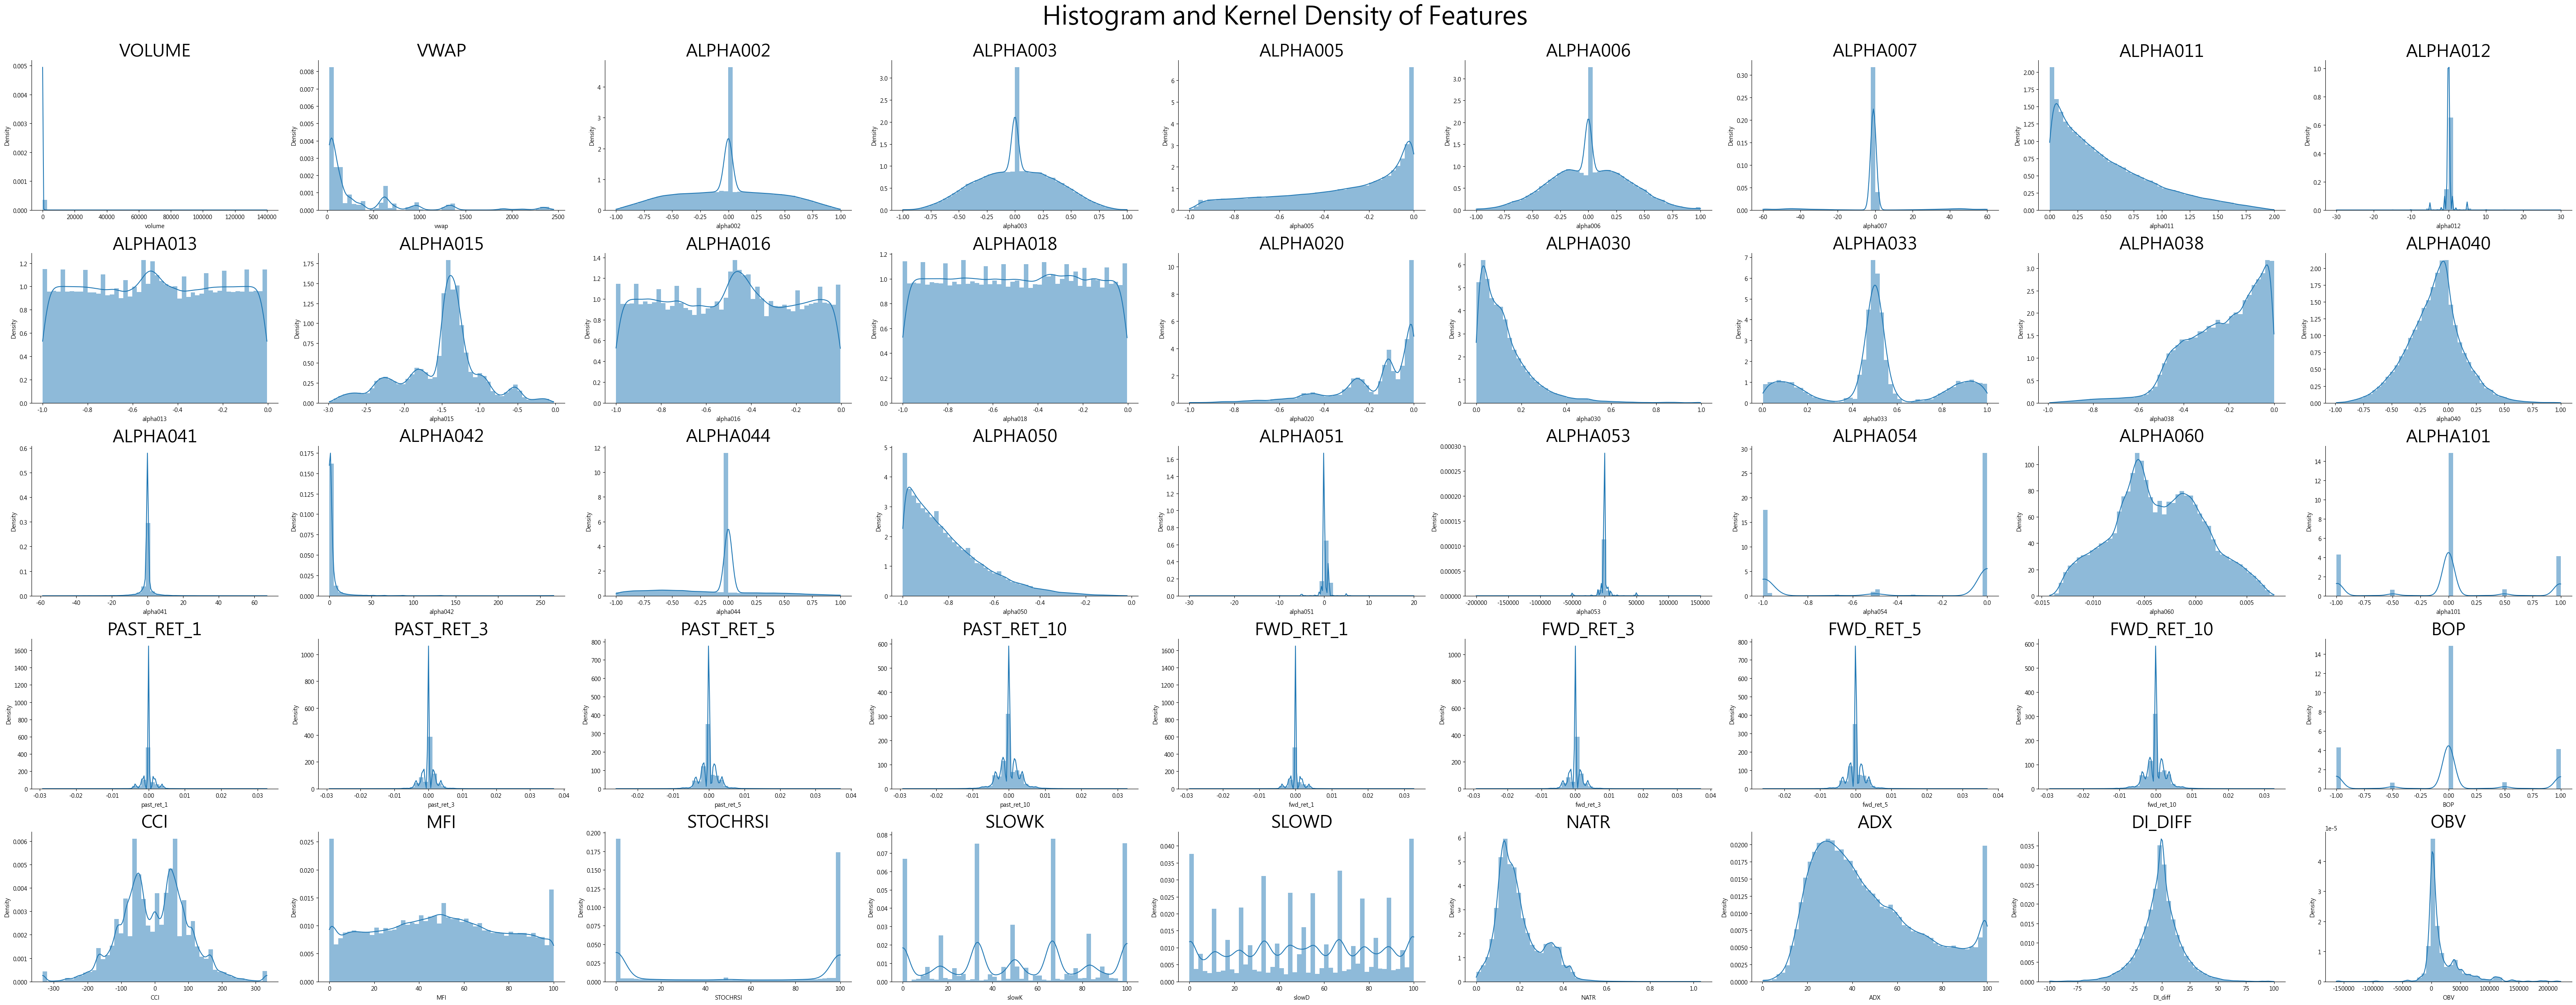

In [12]:
# 排除異常（標準差為0或NaN的column）
abnormal_col = stocks1.filter(items = ["alpha027", "alpha40", "alpha083"]).columns 

# 排除encoded column且只保留過去1,3,5,10分鐘報酬率column
abandon_col = stocks1.filter(items = ['stock_encoded', 'day_encoded','time_encoded', 'close_10min', 'close_20min', 
                                      'open_10min','open_20min', 'past_ret_2', 'past_ret_4', 'past_ret_6', 'past_ret_7', 
                                      'past_ret_8', 'past_ret_9']).columns 

###### 以上排除的column只是不參與視覺化，仍會加入模型訓練 ######

features = stocks1.drop(delete_col, axis=1).drop(abnormal_col, axis=1).drop(abandon_col, axis=1).columns

# 設定圖形大小與子圖
ncols = 9
nrows = (len(features) + ncols - 1) // ncols  # 自動根據特徵數量決定行數
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 5))
axes = axes.flatten()

# 繪圖
for i, feature in enumerate(features):
    ax=axes[i]
    sns.histplot(stocks1[feature], kde=True, ax=ax, bins=50, stat="density", linewidth=0)
    ax.set_title(feature.upper(), fontsize=30)
    
# 多餘子圖清空
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

sns.despine()
fig.suptitle("Histogram and Kernel Density of Features ", fontsize=44)
plt.tight_layout(rect = [0,0,1,0.98])
plt.show()

#### Heatmap of Features

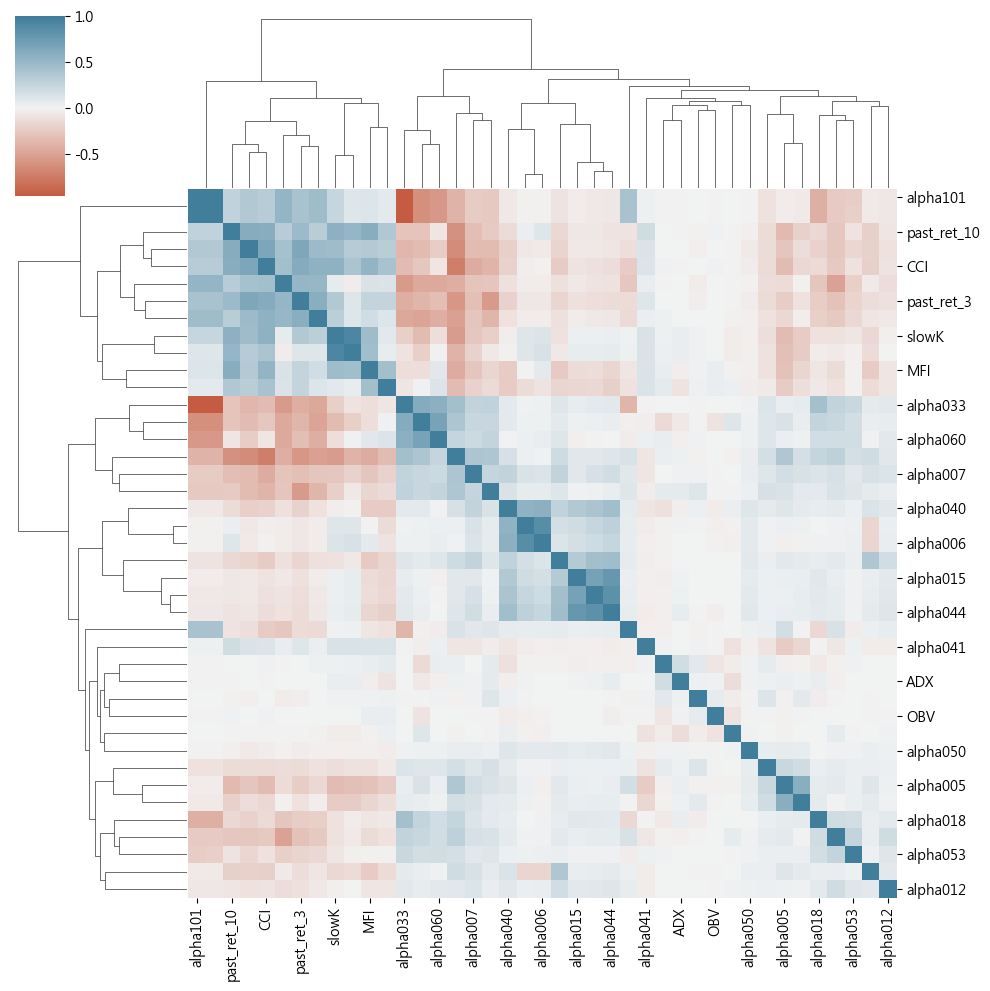

In [13]:
corr = stocks1.drop(ret_col, axis=1).drop(delete_col, axis=1).drop(abnormal_col, axis=1).drop(abandon_col, axis=1).corr()

sns.clustermap(corr, cmap = sns.diverging_palette(20, 230, as_cmap=True),
              center=0)
plt.show()

## Data Splitting

- Split the time-series data into training, validation, and testing sets.

- Employ rolling time windows to split data into 9 training-validation sets.

- Each training-validation set consists of 4 days of training data and 2 days of validation data.

- The last 5 trading days of data are retained as testing sets.

In [14]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

class RollingTimeSeriesCV:
    """
    Generates tuples of train_idx, valid_idx pairs
    按日期分組，預設每次訓練4天，驗證2天，每次驗證間隔2天
    提供兩種版本：預設n_split（暫不設計）、預設訓練/驗證時間長度
    """
# 共25檔股票，每日分K資料共266筆
    def __init__(self, 
                 DATA=None,
                #  n_splits=5,
                 period_length=266,  # 每個基本時間段長度（例如：每天有266分鐘的資料）
                 train_day_length=4,  # 每次train 4天資料
                 valid_day_length=2,  # 每次valid 2天資料
                 step_day_length=2,  # 驗證集間隔2天
                 test_day_length=5,  #test資料共5天
                #  lookahead=None,  # 往前面的時間回推
                 date_idx='date'):
        self.DATA = DATA
        # self.n_splits = n_splits
        # self.lookahead = lookahead
        # self.period_length = period_length
        self.valid_length = int(valid_day_length * period_length)
        self.train_length = int(train_day_length * period_length)
        self.step_length = int(step_day_length * period_length)
        self.test_day_length = int(test_day_length * period_length)   

        self.date_idx = date_idx
        self.train_valid_time_idxs = []
        
        DATA_time_each = (self.DATA).index.get_level_values(self.date_idx)  #每筆資料的時間
        self.DATA_time = DATA_time_each.unique()   # 資料的時間序
        DATA_time_idx = [i for i,j in enumerate(self.DATA_time)]   # 時間序的idx
        self.test_times = self.DATA_time[-self.test_day_length:]
        self.test_time_idxs =  DATA_time_idx[-self.test_day_length:]

        
        # 最後3天資料當作test data最後3天資料當作test data  
        self.DATA_test = (self.DATA).loc[DATA_time_each.isin(self.test_times),]
        self.DATA_train = (self.DATA).loc[~DATA_time_each.isin(self.test_times),]

        # cv = SlidingWindowSplitter(window_length=26600, fh=9975, step_length=9975)   
        self.cv = SlidingWindowSplitter(window_length=self.train_length, fh=range(1,self.valid_length+1), step_length=self.step_length) 

        # window_length: train data size, 
        # fh: test data size, 
        # step_length: length between each split

        self.unique_datetime = (self.DATA_train).index.get_level_values(self.date_idx).unique()  

    def split(self, y=None, groups=None):

        train_times = []  # 訓練集時間索引
        valid_times = []  # 驗證集時間索引

        for train_idx, valid_idx in self.cv.split(self.unique_datetime):

            train_times = self.unique_datetime[train_idx]  # 訓練集時間索引
            valid_times = self.unique_datetime[valid_idx]  # 訓練集時間索引
        
        # for i in range(self.n_splits):
        #     train_start_idx = i * self.step_length
        #     train_end_idx = train_start_idx + self.train_length - 1
        #     test_start_idx = train_end_idx + self.lookahead + 1
        #     test_end_idx = test_start_idx + self.test_length - 1

        #     split_idx.append([train_start_idx, train_end_idx,
        #                       test_start_idx, test_end_idx])  # 0 21 20 146  # 21 42 41 167

            
            yield train_times, valid_times   # yield返回生成器，逐步生成，暫停執行而非立即停止
            # 每次迴圈都輸出

    def get_times(self):
        return self.DATA_time

    def get_cv_time_idx(self):
        # 迭代存儲每次的時間索引（非原始資料索引，即同時間同個索引，不分ticker）

        for train_idx, valid_idx in self.cv.split(self.unique_datetime):
            self.train_valid_time_idxs.append((train_idx, valid_idx))  # 存儲每次的索引對

        return self.train_valid_time_idxs
    
    def get_train_valid_data(self):
        return self.DATA_train
    
    def get_test_data(self):
        return self.DATA_test

    def get_test_times(self):
        return self.test_times

    def get_test_time_idx(self):
        return  self.test_time_idxs

    def get_n_splits(self):
        return self.cv.get_n_splits(y=self.unique_datetime)


def get_cv(DATA=stocks1):
    return RollingTimeSeriesCV(
        DATA=DATA,
        period_length=266,  # 每個基本時間段長度（例如：每天有266分鐘的資料）
        train_day_length=4,  # 每次train 4天資料
        valid_day_length=2,  # 每次valid 2天資料
        step_day_length=2,  # 驗證集間隔2天
        test_day_length=5,  #test資料共5天
        date_idx='date'
    )

### Time Distribution Plot of Training, Validation, Testing set

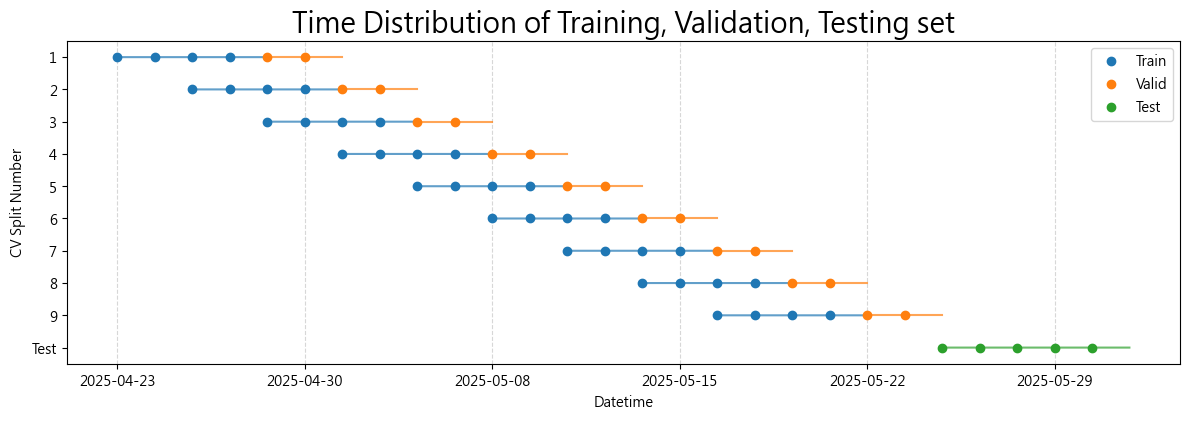

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
minutes_per_day = 266  # 每天的資料點數（例如：每分鐘1筆，共266分鐘）
cv_splits = get_cv().get_n_splits()

for j, (train_idx, valid_idx) in enumerate(get_cv().get_cv_time_idx(), start=1):
    i = get_cv().get_n_splits() - j  # 反向索引，從最後一組開始畫
    # 只取每天一個點（每266筆抓一次）
    train_points = [i for i in train_idx if i % minutes_per_day == 0]
    valid_points = [i for i in valid_idx if i % minutes_per_day == 0]

    # 畫 train（藍色圓點+線線）
    ax.plot(train_points, [i] * len(train_points), 'o', color='tab:blue', label='Train' if i == 0 else "")
    ax.plot(train_idx, [i] * len(train_idx), '-', color='tab:blue', alpha=0.7)

    # 畫 valid（橘色圓點＋線）
    ax.plot(valid_points, [i] * len(valid_points), 'o', color='tab:orange', label='Valid' if i == 0 else "")
    ax.plot(valid_idx, [i] * len(valid_idx), '-', color='tab:orange', alpha=0.7)

test_idx = get_cv().get_test_time_idx()
test_points = [i for i in test_idx if i % minutes_per_day == 0]

ax.plot(test_points, [-1] * len(test_points), 'o', color='tab:green', label='Test')
ax.plot(test_idx, [-1] * len(test_idx), '-', color='tab:green', alpha=0.7)

# 設定 x 軸標籤：每5天（5 × 266）
xticks = np.arange(0, max(test_idx), 5 * minutes_per_day)
ax.set_xticks(xticks)
ax.set_xticklabels(get_cv().get_times()[xticks].date)
ax.set_xlabel("Datetime")

# 設定 Y 軸順序倒轉
yticks = list(range(-1,cv_splits))
ax.set_yticks(yticks)
ax.set_yticklabels(['Test']+[(cv_splits - i) for i in yticks if i>=0])
ax.set_ylim(-0.5 -1, cv_splits - 0.5)
ax.set_ylabel("CV Split Number")

ax.legend()
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.title("Time Distribution of Training, Validation, Testing set", fontsize=20)
plt.show()

## Model Training --LightGBM

- Use `LightGBM` library to train LightGBM model to predict forward returns.

- Use `Optuna` library to efficiently optimize and select the best model parameters.

- Reference: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/12_gradient_boosting_machines/11_intraday_model.ipynb

### Customized Function for `LightGBM` Model

- Create a customized training function for flexible inputs and objectives.

- Use a customized IC (Information Coefficient) metric as the evaluation criterion for model performance.

- Saved the IC stat and FI (Feature Importance) ratio of each model boosting rounds.


In [16]:
# Custom Metric，evaluate model
from scipy.stats import spearmanr

def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    y_true = train_data.get_label()
    if np.std(preds) == 0 or np.std(y_true) == 0:
        return 'ic', 0.0, True  # 避免 NaN
    return 'ic', spearmanr(preds, train_data.get_label(), nan_policy='omit')[0], is_higher_better

## Save Results of every final model in boosting
# ICs (Metric) for results (every boosting round)
def get_scores(result):
    return pd.DataFrame({'train': result['training']['ic'],
                         'valid': result['valid_1']['ic']})

# Feature Importance Ratio for results
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))



### Main Model Setting

- Configure the LightGBM model parameters.

- Output the IC metric and feature importance for each CV process.

- Compute the predicted values for each result and calculate the per-minute correlation between actual and predicted values (IC stat).

In [17]:
# 交叉驗證訓練模型設定

def fit_lgb_cv(lgb_params, target, data=stocks1, num_boost_round=300, debug=False):

  # start = dt.datetime.now()  
  
  # save all IC scores (per boosting), median IC (groupby minutes), feature importance, predicted data for each folds
  # IC metric (IC scores): 每個boosting round一個值，會持續改進（其餘stat都只輸出final model的值）
  # IC stat (median IC): 計算每分鐘各ticker的實際/預測corr coef.，再取所有時間的中位數
  all_ic_metric = []
  all_ic_stat = []
  all_fi = []
  all_preds = []

  for fold, (train_times, valid_times) in enumerate(get_cv(DATA=data).split(), 1):
    
    # create lgb train set
    train_set = data.loc[train_times, :].drop(delete_col, axis=1) #去掉非int, float, bool的欄位
    lgb_train = lgb.Dataset(data=train_set.drop(ret_col, axis=1),
                            label=train_set[target],
                            categorical_feature='stock_encoded')
    
    # create lgb valid set
    valid_set = data.loc[valid_times, :].drop(delete_col, axis=1)
    lgb_valid = lgb.Dataset(data=valid_set.drop(ret_col, axis=1),
                          label=valid_set[target],
                          categorical_feature='stock_encoded', 
                          reference=lgb_train)

    # train model
    evals_result = {}
    model = lgb.train(params=lgb_params,
                      train_set=lgb_train,
                      valid_sets=[lgb_train, lgb_valid],
                    #   valid_names=valid_names,
                      feval=ic_lgbm,
                      num_boost_round=num_boost_round,
                      callbacks=[
                        # boosting過程若50輪之後IC仍未增加min_delta（使用預設值=0），則提前終止
                        lgb.early_stopping(stopping_rounds=50),  
                        lgb.record_evaluation(evals_result)
                        ]
                    #   evals_result=evals_result,
                    #   verbose_eval=50
                      )
    
    ### Save IC metric and Feature importance
    # get train/valid ic scores (of every boosting round)
    scores = get_scores(evals_result)
    all_ic_metric.append(scores)

    # get feature importance (of final model)
    fi = get_fi(model)  
    all_fi.append(fi)

    # generate validation predictions
    valid_X = valid_set.loc[:, model.feature_name()]
    valid_y = valid_set.loc[:, [target]]
    valid_y['pred'] = model.predict(valid_X)
    all_preds.append(valid_y)

    # compute average IC of all minutes (per fold)
    by_minute = valid_y.groupby(valid_set.index.get_level_values('date'))  # IC per minute (of all tickers)
    ic_stat = by_minute.apply(lambda x: spearmanr(x[target], x.pred)[0]).median()  # median IC of all minutes 
    all_ic_stat.append(ic_stat)

    # m, s = divmod((dt.datetime.now()-start).total_seconds(), 60)
    # h, m = divmod(m, 60)

    # print(f'\nFold: {fold:02} | {int(h):02}:{int(m):02}:{s:05.2f} | IC per minute: {daily_ic:.2%}\n')

    if debug:
      break  # debug 模式只跑 1 fold
    
  return dict(all_ic_metric=all_ic_metric, all_preds=all_preds, all_ic_stat=np.median(all_ic_stat), all_fi=all_fi), model  #np.median(all_daily_ic)


### Tuning Parameters by `Optuna`

- Define fixed parameters for the LightGBM model and specified the search space for hyperparameter optimization.

- Optimize the model to maximize the median of the IC median stat (i.e., the correlation coefficient between actual and predicted values per minute), and save the model result with the best IC median performance.











In [ ]:
MODEL_PATH = 'c:\\python_vs\\strategy\\hft_1\\lgb'

In [18]:
# optuna調參（lightgbm原生支援，不需需再用grid cv!!!）

def objective(trial, target, NUM_BOOST_ROUND):
    # 定義要優化的超參數
    lgb_params = {
        'seed': 320,
        'objective': 'regression',
        'metric': ['rmse'],
        'verbosity': -1,  #可消除擾人的 WARNING "[LightGBM] [Warning] No further splits with positive gain, best gain: -inf"
        'boosting_type': 'gbdt',
        'gpu_use_dp' : False,
        'learning_rate': trial.suggest_float('learning_rate', 0.00005, 0.2, log=True), #用log-uniform抽（而非線性取樣）可能的學習率
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0000001, 1, log=True),  #Lasso
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0000001, 1, log=True),  #Ridge
    }

    # CV model fit
    res, model = fit_lgb_cv(lgb_params, target, data=stocks1, num_boost_round=NUM_BOOST_ROUND, debug=False)

    # 自動建立資料夾
    os.makedirs(f'{MODEL_PATH}\\{target}\\best_model', exist_ok=True)
    
    # 儲存最佳模型與附加結果（ic_metric, pred data, fi)
    if trial.number == 0 or res['all_ic_stat'] > trial.study.best_value:

        model.save_model(f'{MODEL_PATH}\\{target}\\best_model\\model_{trial.number:02}.txt')

        # save validation predictions
        pd.concat(res['all_preds'], axis=0).to_hdf(f'{MODEL_PATH}\\{target}\\res.h5', key = f'preds/{trial.number:02}')

        # save feature importance
        pd.concat(res['all_fi'], axis=1).to_hdf(f'{MODEL_PATH}\\{target}\\res.h5', key = f'fi/{trial.number:02}')
    
    # 回傳驗證集的IC (by folds, groupby minutes)，作為調參指標依據
    return res['all_ic_stat']

# res, model = fit_lgb_cv(lgb_params=lgb_params, target=ret_col[0], data=stocks1, num_boost_round=50)
# res['all_ic_metric_mean'][1]
# pd.concat(res['all_preds'], axis=0)
# res['all_ic_stat']

### Additional Setting (early stopping, progressor bar)

Implement an early stopping function and added a progress bar to monitor the optimization process in real time

In [19]:
# 自定義 Early Stopping callback（避免浪費時間做無意義的parameter tuning）
class NoProgressEarlyStopper:
    def __init__(self, patience=10, min_delta=0.01):  # patience: trial個數，min_delta: 可忍受的範圍，預設為0.01（即10次trial內IC增加不到1%就停止）
        self.patience = patience
        self.min_delta = min_delta
        self.best = -float('inf')
        self.counter = 0

    def __call__(self, study, trial):
        if trial.value > self.best + self.min_delta:
            self.best = trial.value
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f"\n⛔Early stopping⛔: No IC improvement > {self.min_delta} for {self.patience} trials.\n")
            study.stop()

# 製作進度條
class TQDMCallback:
    def __init__(self, total, desc='Optuna'):

        self.pbar = tqdm(total=total, desc=desc)
        self.last_time = time.time()

    def __call__(self, study, trial):
        elapsed = time.time() - self.last_time
        self.pbar.set_postfix({   # 進度條旁邊要放的敘述
            'Trial': trial.number,
            'IC': f"{trial.value:.4f}" if trial.value else 'None',
            'Best_IC': f"{study.best_value:.4f}" if study.best_value else 'None',
            'Elapsed': f"{elapsed:.1f}s"
        })
        self.pbar.update(1)
        self.last_time = time.time()

    def close(self):
        self.pbar.close()

### Run Models

- Train and optimize models separately for the expected returns over the next 1, 3, 5, and 10 minutes.

- Perform up to 50 rounds of hyperparameter tuning, with early stopping if the IC median don't improve by more than 0.005 for 10 consecutive rounds.

- Conduct up to 200 boosting iterations per cross-validation fold, with early termination if the IC metric don't improve over 50 consecutive iterations.

- Return a progress bar and reported the IC metric and RMSE for the final boosting result of each CV fold (NOTE: RMSE is just for reference and not used as the boosting evaluation metric)











In [ ]:
N_TRIALS=50  # optuna試驗次數（試驗參數組合個數）
from optuna.samplers import TPESampler

for target in ret_col:
    print(f'\n🎯 Tuning {target}')
    study = optuna.create_study(direction='maximize', 
                                sampler=TPESampler(seed=320))  # 設定隨機種子
    
    tqdm_cb = TQDMCallback(total=N_TRIALS, desc=f"Tuning {target}")

    # 若IC median已10輪未超過最佳IC+0.005，則提前終止試驗
    early_stopper = NoProgressEarlyStopper(patience=10, min_delta=0.005)   

    study.optimize(
        func=partial(objective, target=target, NUM_BOOST_ROUND=200),  # 每個CV內的boosting次數減少為200次，否則模型跑太慢
        n_trials=N_TRIALS,
        callbacks=[tqdm_cb, early_stopper]
    )

    tqdm_cb.close()

    # 儲存結果
    print(f'\n✅ Best IC for {target}: {study.best_value:.4f}')
    print(f'Best Params: {study.best_params}')
    # study.trials_dataframe().to_csv(f'{MODEL_PATH}\\{target}\\optuna_trials.csv')
    study.trials_dataframe().to_hdf(f'{MODEL_PATH}\\{target}\\optuna_trials_df_{target}.h5', key = f'30trial/{target}')
    joblib.dump(study, f"study_{target}.pkl")  # 暫存調參結果


[I 2025-06-15 14:27:35,524] A new study created in memory with name: no-name-e8e95357-30f4-4ca3-84b7-e1db2c51af46



🎯 Tuning fwd_ret_1


Tuning fwd_ret_1:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00138238	training's ic: 0.501909	valid_1's rmse: 0.00133295	valid_1's ic: 0.457911
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[198]	training's rmse: 0.00133155	training's ic: 0.504389	valid_1's rmse: 0.00155676	valid_1's ic: 0.435479
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00141582	training's ic: 0.483396	valid_1's rmse: 0.00149076	valid_1's ic: 0.44615
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00148775	training's ic: 0.479318	valid_1's rmse: 0.00141172	valid_1's ic: 0.474734
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0

[I 2025-06-15 14:28:13,250] Trial 0 finished with value: 0.4889186825329069 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.4889186825329069.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00141273	training's ic: 0.483341	valid_1's rmse: 0.00135314	valid_1's ic: 0.444867
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00136408	training's ic: 0.479315	valid_1's rmse: 0.00157518	valid_1's ic: 0.428157
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0014473	training's ic: 0.460278	valid_1's rmse: 0.0015102	valid_1's ic: 0.439099
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00151948	training's ic: 0.457717	valid_1's rmse: 0.00143537	valid_1's ic: 0.462611
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.

[I 2025-06-15 14:29:02,248] Trial 1 finished with value: 0.4810338699036491 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.4889186825329069.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00145597	training's ic: 0.480834	valid_1's rmse: 0.00138383	valid_1's ic: 0.440931
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00141147	training's ic: 0.475779	valid_1's rmse: 0.0016157	valid_1's ic: 0.424547
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00149525	training's ic: 0.451924	valid_1's rmse: 0.00154645	valid_1's ic: 0.442196
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00156565	training's ic: 0.449938	valid_1's rmse: 0.00147081	valid_1's ic: 0.460244
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0

[I 2025-06-15 14:29:48,498] Trial 2 finished with value: 0.4715543163642386 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.7526293178205452, 'bagging_fraction': 0.9308281522181763, 'bagging_freq': 6, 'lambda_l1': 0.2810064370075652, 'lambda_l2': 0.1661099025892053}. Best is trial 0 with value: 0.4889186825329069.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	training's rmse: 0.00132547	training's ic: 0.552222	valid_1's rmse: 0.00132485	valid_1's ic: 0.464448
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	training's rmse: 0.00125583	training's ic: 0.571758	valid_1's rmse: 0.00154539	valid_1's ic: 0.440986
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's rmse: 0.00138067	training's ic: 0.514506	valid_1's rmse: 0.00148647	valid_1's ic: 0.448012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's rmse: 0.00145298	training's ic: 0.51219	valid_1's rmse: 0.00140242	valid_1's ic: 0.480551
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's rmse: 0.00139135	training's ic: 0.520086	valid_1's rmse: 0.0012931	valid_1's 

[I 2025-06-15 14:30:25,235] Trial 3 finished with value: 0.49679084452626865 and parameters: {'learning_rate': 0.08213147516092259, 'num_leaves': 118, 'min_data_in_leaf': 413, 'feature_fraction': 0.6875119526507484, 'bagging_fraction': 0.764125933319521, 'bagging_freq': 4, 'lambda_l1': 3.0395225946618396e-05, 'lambda_l2': 2.1507415220123508e-07}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	training's rmse: 0.00133464	training's ic: 0.542035	valid_1's rmse: 0.00132458	valid_1's ic: 0.465256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	training's rmse: 0.00129651	training's ic: 0.534126	valid_1's rmse: 0.00155062	valid_1's ic: 0.435657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	training's rmse: 0.00140287	training's ic: 0.493901	valid_1's rmse: 0.00148938	valid_1's ic: 0.446088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	training's rmse: 0.00146724	training's ic: 0.495943	valid_1's rmse: 0.0014068	valid_1's ic: 0.476298
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	training's rmse: 0.00139886	training's ic: 0.509957	valid_1's rmse: 0.00129546	valid_1

[I 2025-06-15 14:31:09,075] Trial 4 finished with value: 0.490950267603179 and parameters: {'learning_rate': 0.09366026793731969, 'num_leaves': 72, 'min_data_in_leaf': 895, 'feature_fraction': 0.6060339469862899, 'bagging_fraction': 0.7994101633717404, 'bagging_freq': 7, 'lambda_l1': 0.00011992319902296268, 'lambda_l2': 6.948410742966882e-07}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00158789	training's ic: 0.471097	valid_1's rmse: 0.00149796	valid_1's ic: 0.434335
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00153562	training's ic: 0.467457	valid_1's rmse: 0.0017274	valid_1's ic: 0.418696
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00161645	training's ic: 0.444525	valid_1's rmse: 0.00166363	valid_1's ic: 0.434444
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00169445	training's ic: 0.446046	valid_1's rmse: 0.00159322	valid_1's ic: 0.460749
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	training's rmse: 0.00163595	tra

[I 2025-06-15 14:31:53,857] Trial 5 finished with value: 0.4715361831919521 and parameters: {'learning_rate': 0.0003728648904522368, 'num_leaves': 56, 'min_data_in_leaf': 358, 'feature_fraction': 0.6572426425102978, 'bagging_fraction': 0.6386589885879134, 'bagging_freq': 3, 'lambda_l1': 0.12188743153893443, 'lambda_l2': 1.1584052567398603e-05}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	training's rmse: 0.00159987	training's ic: 0.460557	valid_1's rmse: 0.00150895	valid_1's ic: 0.428678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	training's rmse: 0.00154704	training's ic: 0.459899	valid_1's rmse: 0.00173818	valid_1's ic: 0.413161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	training's rmse: 0.00162564	training's ic: 0.432553	valid_1's rmse: 0.00167258	valid_1's ic: 0.425229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	training's rmse: 0.0017039	training's ic: 0.431139	valid_1's rmse: 0.0016022	valid_1's ic: 0.451804
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	training's rmse: 0.00163652	training's ic: 0.443183	valid_1's rmse: 0.00150417	valid_1'

[I 2025-06-15 14:32:31,740] Trial 6 finished with value: 0.46016239655881963 and parameters: {'learning_rate': 0.00037909562026305926, 'num_leaves': 33, 'min_data_in_leaf': 933, 'feature_fraction': 0.6415098613643865, 'bagging_fraction': 0.7027009381105671, 'bagging_freq': 5, 'lambda_l1': 0.19602693291302653, 'lambda_l2': 4.750873985587134e-05}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	training's rmse: 0.00119728	training's ic: 0.617747	valid_1's rmse: 0.00132081	valid_1's ic: 0.468394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	training's rmse: 0.00113504	training's ic: 0.626032	valid_1's rmse: 0.00153942	valid_1's ic: 0.446396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	training's rmse: 0.00124605	training's ic: 0.598542	valid_1's rmse: 0.00148477	valid_1's ic: 0.450605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	training's rmse: 0.00130591	training's ic: 0.603996	valid_1's rmse: 0.00140353	valid_1's ic: 0.480161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	training's rmse: 0.00123672	training's ic: 0.608286	valid_1's rmse: 0.00128836	val

[I 2025-06-15 14:33:35,475] Trial 7 finished with value: 0.4933067056952675 and parameters: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00141047	training's ic: 0.482126	valid_1's rmse: 0.00135088	valid_1's ic: 0.445158
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00136141	training's ic: 0.478666	valid_1's rmse: 0.00157256	valid_1's ic: 0.428644
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00144451	training's ic: 0.459229	valid_1's rmse: 0.00150649	valid_1's ic: 0.439847
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00151699	training's ic: 0.456918	valid_1's rmse: 0.0014321	valid_1's ic: 0.463117
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0

[I 2025-06-15 14:34:29,942] Trial 8 finished with value: 0.4837081814757178 and parameters: {'learning_rate': 0.008785959989227338, 'num_leaves': 12, 'min_data_in_leaf': 180, 'feature_fraction': 0.8167642991522106, 'bagging_fraction': 0.9059715226183904, 'bagging_freq': 1, 'lambda_l1': 1.3276426917041082e-06, 'lambda_l2': 0.00037192790119216303}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00154511	training's ic: 0.498076	valid_1's rmse: 0.00146176	valid_1's ic: 0.444524
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	training's rmse: 0.00151233	training's ic: 0.499349	valid_1's rmse: 0.00170812	valid_1's ic: 0.425517
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00157496	training's ic: 0.477087	valid_1's rmse: 0.00162705	valid_1's ic: 0.43394
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00165152	training's ic: 0.478127	valid_1's rmse: 0.00155615	valid_1's ic: 0.467036
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00158555	tra

[I 2025-06-15 14:35:42,388] Trial 9 finished with value: 0.478357745595635 and parameters: {'learning_rate': 0.0009596256753128148, 'num_leaves': 61, 'min_data_in_leaf': 211, 'feature_fraction': 0.9731059153559242, 'bagging_fraction': 0.7115190617410472, 'bagging_freq': 10, 'lambda_l1': 2.2328160399607538e-06, 'lambda_l2': 0.004851096120995277}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	training's rmse: 0.00160601	training's ic: 0.472428	valid_1's rmse: 0.00151482	valid_1's ic: 0.432379
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's rmse: 0.00155334	training's ic: 0.471029	valid_1's rmse: 0.00174412	valid_1's ic: 0.408087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's rmse: 0.00163349	training's ic: 0.448537	valid_1's rmse: 0.00168032	valid_1's ic: 0.42534
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's rmse: 0.00171255	training's ic: 0.448813	valid_1's rmse: 0.0016108	valid_1's ic: 0.455847
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.00164515	training's ic: 0.457886	valid_1's rmse: 0.00151338	valid_1's ic

[I 2025-06-15 14:36:11,491] Trial 10 finished with value: 0.4706819288327452 and parameters: {'learning_rate': 5.725730322696381e-05, 'num_leaves': 124, 'min_data_in_leaf': 624, 'feature_fraction': 0.8788177122582159, 'bagging_fraction': 0.9874534742396864, 'bagging_freq': 9, 'lambda_l1': 5.2541968526492904e-05, 'lambda_l2': 2.615962754986802e-06}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	training's rmse: 0.00116681	training's ic: 0.62577	valid_1's rmse: 0.00132799	valid_1's ic: 0.462981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	training's rmse: 0.00108931	training's ic: 0.640661	valid_1's rmse: 0.00154514	valid_1's ic: 0.443367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	training's rmse: 0.00122616	training's ic: 0.601304	valid_1's rmse: 0.00148773	valid_1's ic: 0.450919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	training's rmse: 0.00129698	training's ic: 0.600301	valid_1's rmse: 0.00140374	valid_1's ic: 0.478347
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's rmse: 0.00121279	training's ic: 0.611225	valid_1's rmse: 0.00129432	valid_1's

[I 2025-06-15 14:36:58,679] Trial 11 finished with value: 0.4936294524005549 and parameters: {'learning_rate': 0.05474581222166177, 'num_leaves': 101, 'min_data_in_leaf': 15, 'feature_fraction': 0.711834130891086, 'bagging_fraction': 0.7938113866683341, 'bagging_freq': 2, 'lambda_l1': 0.002433190893029561, 'lambda_l2': 0.006107749604816011}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's rmse: 0.00133331	training's ic: 0.544439	valid_1's rmse: 0.00132863	valid_1's ic: 0.461891
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's rmse: 0.00126311	training's ic: 0.56394	valid_1's rmse: 0.00154753	valid_1's ic: 0.437699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's rmse: 0.00137144	training's ic: 0.521286	valid_1's rmse: 0.00148957	valid_1's ic: 0.44431
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's rmse: 0.00144432	training's ic: 0.517461	valid_1's rmse: 0.00140688	valid_1's ic: 0.47296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's rmse: 0.00139459	training's ic: 0.516351	valid_1's rmse: 0.00129862	valid_1's i

[I 2025-06-15 14:37:22,177] Trial 12 finished with value: 0.4869551389655225 and parameters: {'learning_rate': 0.17209046488269983, 'num_leaves': 101, 'min_data_in_leaf': 392, 'feature_fraction': 0.6962452333903277, 'bagging_fraction': 0.8526925148026978, 'bagging_freq': 3, 'lambda_l1': 0.0016713134209969684, 'lambda_l2': 0.01882508332773591}. Best is trial 3 with value: 0.49679084452626865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[196]	training's rmse: 0.00133682	training's ic: 0.541008	valid_1's rmse: 0.00132425	valid_1's ic: 0.465282
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[188]	training's rmse: 0.00128866	training's ic: 0.54127	valid_1's rmse: 0.00154674	valid_1's ic: 0.440172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	training's rmse: 0.00139672	training's ic: 0.499194	valid_1's rmse: 0.00148546	valid_1's ic: 0.450902
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0014352	training's ic: 0.525016	valid_1's rmse: 0.00140323	valid_1's ic: 0.477035
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[196]	training's rmse: 0.00137612	trai

[I 2025-06-15 14:38:12,543] Trial 13 finished with value: 0.49310473249601794 and parameters: {'learning_rate': 0.04854178874929791, 'num_leaves': 103, 'min_data_in_leaf': 715, 'feature_fraction': 0.7101422103373515, 'bagging_fraction': 0.7536316413028572, 'bagging_freq': 3, 'lambda_l1': 1.8502458735490312e-05, 'lambda_l2': 0.8402146144987566}. Best is trial 3 with value: 0.49679084452626865.
[I 2025-06-15 14:38:12,619] A new study created in memory with name: no-name-de4ba912-49d5-46f1-869d-b7b8bdef98ba



⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_1: 0.4968
Best Params: {'learning_rate': 0.08213147516092259, 'num_leaves': 118, 'min_data_in_leaf': 413, 'feature_fraction': 0.6875119526507484, 'bagging_fraction': 0.764125933319521, 'bagging_freq': 4, 'lambda_l1': 3.0395225946618396e-05, 'lambda_l2': 2.1507415220123508e-07}

🎯 Tuning fwd_ret_3


Tuning fwd_ret_3:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00175659	training's ic: 0.497072	valid_1's rmse: 0.00170918	valid_1's ic: 0.437043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	training's rmse: 0.00172762	training's ic: 0.482643	valid_1's rmse: 0.00209803	valid_1's ic: 0.404496
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	training's rmse: 0.00187847	training's ic: 0.468712	valid_1's rmse: 0.00197781	valid_1's ic: 0.412495
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00195338	training's ic: 0.479823	valid_1's rmse: 0.00183353	valid_1's ic: 0.449581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	training's rmse: 0.00186971	training's ic: 0.471568	vali

[I 2025-06-15 14:39:00,696] Trial 0 finished with value: 0.4649085336482267 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.4649085336482267.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00179873	training's ic: 0.469099	valid_1's rmse: 0.00173337	valid_1's ic: 0.417041
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00173632	training's ic: 0.468608	valid_1's rmse: 0.00210118	valid_1's ic: 0.404365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[140]	training's rmse: 0.00191559	training's ic: 0.45006	valid_1's rmse: 0.00200105	valid_1's ic: 0.400969
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00199601	training's ic: 0.45041	valid_1's rmse: 0.00186273	valid_1's ic: 0.432869
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00189646	trai

[I 2025-06-15 14:39:47,061] Trial 1 finished with value: 0.4623378128062477 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.4649085336482267.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00184997	training's ic: 0.458825	valid_1's rmse: 0.00176618	valid_1's ic: 0.409432
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0017888	training's ic: 0.455907	valid_1's rmse: 0.0021371	valid_1's ic: 0.402243
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0019386	training's ic: 0.442205	valid_1's rmse: 0.00201607	valid_1's ic: 0.407592
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00205322	training's ic: 0.432953	valid_1's rmse: 0.00189676	valid_1's ic: 0.424134
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0

[I 2025-06-15 14:40:33,262] Trial 2 finished with value: 0.44805295004884216 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.7526293178205452, 'bagging_fraction': 0.9308281522181763, 'bagging_freq': 6, 'lambda_l1': 0.2810064370075652, 'lambda_l2': 0.1661099025892053}. Best is trial 0 with value: 0.4649085336482267.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	training's rmse: 0.00161807	training's ic: 0.595857	valid_1's rmse: 0.00169272	valid_1's ic: 0.448206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's rmse: 0.00169162	training's ic: 0.510297	valid_1's rmse: 0.00209206	valid_1's ic: 0.401617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	training's rmse: 0.00183614	training's ic: 0.501487	valid_1's rmse: 0.00197021	valid_1's ic: 0.412795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's rmse: 0.00188839	training's ic: 0.52858	valid_1's rmse: 0.00182899	valid_1's ic: 0.450114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's rmse: 0.00185847	training's ic: 0.487717	valid_1's rmse: 0.00166623	valid_1'

[I 2025-06-15 14:41:02,437] Trial 3 finished with value: 0.46582679628736756 and parameters: {'learning_rate': 0.08213147516092259, 'num_leaves': 118, 'min_data_in_leaf': 413, 'feature_fraction': 0.6875119526507484, 'bagging_fraction': 0.764125933319521, 'bagging_freq': 4, 'lambda_l1': 3.0395225946618396e-05, 'lambda_l2': 2.1507415220123508e-07}. Best is trial 3 with value: 0.46582679628736756.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	training's rmse: 0.00170317	training's ic: 0.534901	valid_1's rmse: 0.00169587	valid_1's ic: 0.446623
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00171684	training's ic: 0.481895	valid_1's rmse: 0.00210038	valid_1's ic: 0.392332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00186744	training's ic: 0.467407	valid_1's rmse: 0.00197293	valid_1's ic: 0.414653
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	training's rmse: 0.0019294	training's ic: 0.496289	valid_1's rmse: 0.00182951	valid_1's ic: 0.450008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.0018804	training's ic: 0.461975	valid_1's rmse: 0.00167382	valid_1's 

[I 2025-06-15 14:41:32,898] Trial 4 finished with value: 0.4676572458527476 and parameters: {'learning_rate': 0.09366026793731969, 'num_leaves': 72, 'min_data_in_leaf': 895, 'feature_fraction': 0.6060339469862899, 'bagging_fraction': 0.7994101633717404, 'bagging_freq': 7, 'lambda_l1': 0.00011992319902296268, 'lambda_l2': 6.948410742966882e-07}. Best is trial 4 with value: 0.4676572458527476.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	training's rmse: 0.00200537	training's ic: 0.452571	valid_1's rmse: 0.00190137	valid_1's ic: 0.405327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	training's rmse: 0.00193834	training's ic: 0.444047	valid_1's rmse: 0.00226939	valid_1's ic: 0.388621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	training's rmse: 0.00209399	training's ic: 0.429086	valid_1's rmse: 0.00215543	valid_1's ic: 0.404225
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	training's rmse: 0.00221034	training's ic: 0.423789	valid_1's rmse: 0.00203369	valid_1's ic: 0.420929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's rmse: 0.00210033	training's ic: 0.423274	valid_1's rmse: 0.00186261	valid_

[I 2025-06-15 14:42:08,032] Trial 5 finished with value: 0.44755265912784015 and parameters: {'learning_rate': 0.0003728648904522368, 'num_leaves': 56, 'min_data_in_leaf': 358, 'feature_fraction': 0.6572426425102978, 'bagging_fraction': 0.6386589885879134, 'bagging_freq': 3, 'lambda_l1': 0.12188743153893443, 'lambda_l2': 1.1584052567398603e-05}. Best is trial 4 with value: 0.4676572458527476.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00199853	training's ic: 0.435537	valid_1's rmse: 0.00189466	valid_1's ic: 0.391425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.0019429	training's ic: 0.422793	valid_1's rmse: 0.00227342	valid_1's ic: 0.374948
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00208509	training's ic: 0.408907	valid_1's rmse: 0.00214676	valid_1's ic: 0.394461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	training's rmse: 0.00221538	training's ic: 0.407741	valid_1's rmse: 0.00203823	valid_1's ic: 0.408319
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00208668	training's ic: 0.4

[I 2025-06-15 14:42:41,813] Trial 6 finished with value: 0.4310188519980176 and parameters: {'learning_rate': 0.00037909562026305926, 'num_leaves': 33, 'min_data_in_leaf': 933, 'feature_fraction': 0.6415098613643865, 'bagging_fraction': 0.7027009381105671, 'bagging_freq': 5, 'lambda_l1': 0.19602693291302653, 'lambda_l2': 4.750873985587134e-05}. Best is trial 4 with value: 0.4676572458527476.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[157]	training's rmse: 0.0013912	training's ic: 0.685227	valid_1's rmse: 0.00168815	valid_1's ic: 0.449984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	training's rmse: 0.00154517	training's ic: 0.598034	valid_1's rmse: 0.0020747	valid_1's ic: 0.407926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's rmse: 0.00172509	training's ic: 0.577533	valid_1's rmse: 0.00197332	valid_1's ic: 0.410523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	training's rmse: 0.00168467	training's ic: 0.621362	valid_1's rmse: 0.00181207	valid_1's ic: 0.460745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's rmse: 0.00169729	training's ic: 0.583525	valid_1's rmse: 0.00165

[I 2025-06-15 14:43:29,987] Trial 7 finished with value: 0.4692105913447171 and parameters: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}. Best is trial 7 with value: 0.4692105913447171.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00179563	training's ic: 0.467982	valid_1's rmse: 0.00172888	valid_1's ic: 0.417893
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00173261	training's ic: 0.466767	valid_1's rmse: 0.0020968	valid_1's ic: 0.404642
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00187922	training's ic: 0.460345	valid_1's rmse: 0.00197808	valid_1's ic: 0.404192
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00199301	training's ic: 0.451079	valid_1's rmse: 0.00185769	valid_1's ic: 0.436755
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0

[I 2025-06-15 14:44:13,166] Trial 8 finished with value: 0.46394659752458645 and parameters: {'learning_rate': 0.008785959989227338, 'num_leaves': 12, 'min_data_in_leaf': 180, 'feature_fraction': 0.8167642991522106, 'bagging_fraction': 0.9059715226183904, 'bagging_freq': 1, 'lambda_l1': 1.3276426917041082e-06, 'lambda_l2': 0.00037192790119216303}. Best is trial 7 with value: 0.4692105913447171.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00194652	training's ic: 0.492619	valid_1's rmse: 0.00185228	valid_1's ic: 0.420081
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00187971	training's ic: 0.49339	valid_1's rmse: 0.00222215	valid_1's ic: 0.401194
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00203184	training's ic: 0.485483	valid_1's rmse: 0.00210406	valid_1's ic: 0.402442
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00214981	training's ic: 0.474974	valid_1's rmse: 0.00198545	valid_1's ic: 0.435729
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0

[I 2025-06-15 14:45:16,361] Trial 9 finished with value: 0.4566144713873551 and parameters: {'learning_rate': 0.0009596256753128148, 'num_leaves': 61, 'min_data_in_leaf': 211, 'feature_fraction': 0.9731059153559242, 'bagging_fraction': 0.7115190617410472, 'bagging_freq': 10, 'lambda_l1': 2.2328160399607538e-06, 'lambda_l2': 0.004851096120995277}. Best is trial 7 with value: 0.4692105913447171.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	training's rmse: 0.00201571	training's ic: 0.460774	valid_1's rmse: 0.00191097	valid_1's ic: 0.403996
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.0019463	training's ic: 0.452458	valid_1's rmse: 0.00227653	valid_1's ic: 0.389957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's rmse: 0.00210175	training's ic: 0.446004	valid_1's rmse: 0.00216271	valid_1's ic: 0.396211
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	training's rmse: 0.00221968	training's ic: 0.434636	valid_1's rmse: 0.0020423	valid_1's ic: 0.423173
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00209975	training's ic: 0.438989	valid_1's rmse: 0.001862

[I 2025-06-15 14:45:45,513] Trial 10 finished with value: 0.4539156301272974 and parameters: {'learning_rate': 5.725730322696381e-05, 'num_leaves': 92, 'min_data_in_leaf': 624, 'feature_fraction': 0.8451572628925155, 'bagging_fraction': 0.988698650021125, 'bagging_freq': 1, 'lambda_l1': 0.003095456676454308, 'lambda_l2': 0.006964481274076286}. Best is trial 7 with value: 0.4692105913447171.
[I 2025-06-15 14:45:45,611] A new study created in memory with name: no-name-924040fe-02d9-4546-be81-fed957c3fb62



⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_3: 0.4692
Best Params: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}

🎯 Tuning fwd_ret_5


Tuning fwd_ret_5:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[199]	training's rmse: 0.00196102	training's ic: 0.516728	valid_1's rmse: 0.00194722	valid_1's ic: 0.448356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	training's rmse: 0.00198298	training's ic: 0.488761	valid_1's rmse: 0.00246932	valid_1's ic: 0.406471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	training's rmse: 0.00230398	training's ic: 0.458749	valid_1's rmse: 0.00237056	valid_1's ic: 0.417553
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00222915	training's ic: 0.507636	valid_1's rmse: 0.00208878	valid_1's ic: 0.451075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	training's rmse: 0.00219474	training's ic: 0.465108	valid_1

[I 2025-06-15 14:46:30,239] Trial 0 finished with value: 0.4667735897719053 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.4667735897719053.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00201546	training's ic: 0.481683	valid_1's rmse: 0.00197477	valid_1's ic: 0.42409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	training's rmse: 0.0020317	training's ic: 0.462772	valid_1's rmse: 0.00249792	valid_1's ic: 0.410605
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00214512	training's ic: 0.48543	valid_1's rmse: 0.0022809	valid_1's ic: 0.404535
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0022795	training's ic: 0.475054	valid_1's rmse: 0.00211683	valid_1's ic: 0.434953
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00214874	trainin

[I 2025-06-15 14:47:17,475] Trial 1 finished with value: 0.4562671028783893 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.4667735897719053.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00207381	training's ic: 0.470414	valid_1's rmse: 0.00201575	valid_1's ic: 0.417669
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00202322	training's ic: 0.470488	valid_1's rmse: 0.00249188	valid_1's ic: 0.409342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's rmse: 0.00234576	training's ic: 0.447559	valid_1's rmse: 0.0024075	valid_1's ic: 0.410097
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00235745	training's ic: 0.458611	valid_1's rmse: 0.00215015	valid_1's ic: 0.427673
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00220853	trai

[I 2025-06-15 14:48:05,336] Trial 2 finished with value: 0.4525977800454092 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.7526293178205452, 'bagging_fraction': 0.9308281522181763, 'bagging_freq': 6, 'lambda_l1': 0.2810064370075652, 'lambda_l2': 0.1661099025892053}. Best is trial 0 with value: 0.4667735897719053.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	training's rmse: 0.00180526	training's ic: 0.6095	valid_1's rmse: 0.00192696	valid_1's ic: 0.456621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's rmse: 0.00195048	training's ic: 0.516605	valid_1's rmse: 0.00247026	valid_1's ic: 0.396761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's rmse: 0.00210292	training's ic: 0.531455	valid_1's rmse: 0.00227911	valid_1's ic: 0.413508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's rmse: 0.00219095	training's ic: 0.535484	valid_1's rmse: 0.00208456	valid_1's ic: 0.454857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's rmse: 0.00211212	training's ic: 0.509964	valid_1's rmse: 0.00193691	valid_1's 

[I 2025-06-15 14:48:34,978] Trial 3 finished with value: 0.466638770451012 and parameters: {'learning_rate': 0.08213147516092259, 'num_leaves': 118, 'min_data_in_leaf': 413, 'feature_fraction': 0.6875119526507484, 'bagging_fraction': 0.764125933319521, 'bagging_freq': 4, 'lambda_l1': 3.0395225946618396e-05, 'lambda_l2': 2.1507415220123508e-07}. Best is trial 0 with value: 0.4667735897719053.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	training's rmse: 0.0019214	training's ic: 0.541016	valid_1's rmse: 0.00193657	valid_1's ic: 0.457161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's rmse: 0.00191479	training's ic: 0.516935	valid_1's rmse: 0.0024633	valid_1's ic: 0.388271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00214468	training's ic: 0.492664	valid_1's rmse: 0.00227587	valid_1's ic: 0.41781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's rmse: 0.0022404	training's ic: 0.501993	valid_1's rmse: 0.00209467	valid_1's ic: 0.447762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00214425	training's ic: 0.478918	valid_1's rmse: 0.00194795	valid_1's ic

[I 2025-06-15 14:49:05,076] Trial 4 finished with value: 0.4687145601426566 and parameters: {'learning_rate': 0.09366026793731969, 'num_leaves': 72, 'min_data_in_leaf': 895, 'feature_fraction': 0.6060339469862899, 'bagging_fraction': 0.7994101633717404, 'bagging_freq': 7, 'lambda_l1': 0.00011992319902296268, 'lambda_l2': 6.948410742966882e-07}. Best is trial 4 with value: 0.4687145601426566.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	training's rmse: 0.00226168	training's ic: 0.458904	valid_1's rmse: 0.00218159	valid_1's ic: 0.412985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	training's rmse: 0.00220292	training's ic: 0.457505	valid_1's rmse: 0.00264594	valid_1's ic: 0.402315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	training's rmse: 0.00242787	training's ic: 0.454928	valid_1's rmse: 0.0024822	valid_1's ic: 0.409958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	training's rmse: 0.00256022	training's ic: 0.447638	valid_1's rmse: 0.00231298	valid_1's ic: 0.423156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	training's rmse: 0.00239389	training's ic: 0.44652	valid_1's rmse: 0.00214408	valid_

[I 2025-06-15 14:49:46,894] Trial 5 finished with value: 0.4525251556459301 and parameters: {'learning_rate': 0.0003728648904522368, 'num_leaves': 56, 'min_data_in_leaf': 358, 'feature_fraction': 0.6572426425102978, 'bagging_fraction': 0.6386589885879134, 'bagging_freq': 3, 'lambda_l1': 0.12188743153893443, 'lambda_l2': 1.1584052567398603e-05}. Best is trial 4 with value: 0.4687145601426566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00225322	training's ic: 0.440579	valid_1's rmse: 0.00217364	valid_1's ic: 0.403168
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's rmse: 0.0022111	training's ic: 0.429578	valid_1's rmse: 0.00265302	valid_1's ic: 0.387508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's rmse: 0.00242987	training's ic: 0.431236	valid_1's rmse: 0.00248382	valid_1's ic: 0.409506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	training's rmse: 0.00256015	training's ic: 0.421325	valid_1's rmse: 0.0023125	valid_1's ic: 0.404418
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.00240188	training's ic: 0.423489	valid_1's rmse: 0.0021

[I 2025-06-15 14:50:22,390] Trial 6 finished with value: 0.4387469257970105 and parameters: {'learning_rate': 0.00037909562026305926, 'num_leaves': 33, 'min_data_in_leaf': 933, 'feature_fraction': 0.6415098613643865, 'bagging_fraction': 0.7027009381105671, 'bagging_freq': 5, 'lambda_l1': 0.19602693291302653, 'lambda_l2': 4.750873985587134e-05}. Best is trial 4 with value: 0.4687145601426566.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	training's rmse: 0.00156171	training's ic: 0.694502	valid_1's rmse: 0.00192091	valid_1's ic: 0.453855
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's rmse: 0.00177778	training's ic: 0.610059	valid_1's rmse: 0.00244665	valid_1's ic: 0.397291
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.00192538	training's ic: 0.615999	valid_1's rmse: 0.00228937	valid_1's ic: 0.40237
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	training's rmse: 0.00200785	training's ic: 0.616356	valid_1's rmse: 0.00207029	valid_1's ic: 0.45907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's rmse: 0.00206438	training's ic: 0.569809	valid_1's rmse: 0.00194797	valid_1's

[I 2025-06-15 14:51:16,376] Trial 7 finished with value: 0.46502530024061817 and parameters: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}. Best is trial 4 with value: 0.4687145601426566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00201184	training's ic: 0.480946	valid_1's rmse: 0.00197391	valid_1's ic: 0.423276
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00195482	training's ic: 0.485402	valid_1's rmse: 0.00244979	valid_1's ic: 0.407598
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[195]	training's rmse: 0.00214715	training's ic: 0.484076	valid_1's rmse: 0.00228367	valid_1's ic: 0.406785
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00227896	training's ic: 0.473922	valid_1's rmse: 0.00211371	valid_1's ic: 0.435759
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 

[I 2025-06-15 14:52:09,294] Trial 8 finished with value: 0.4577129776032173 and parameters: {'learning_rate': 0.008785959989227338, 'num_leaves': 12, 'min_data_in_leaf': 180, 'feature_fraction': 0.8167642991522106, 'bagging_fraction': 0.9059715226183904, 'bagging_freq': 1, 'lambda_l1': 1.3276426917041082e-06, 'lambda_l2': 0.00037192790119216303}. Best is trial 4 with value: 0.4687145601426566.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[137]	training's rmse: 0.00221437	training's ic: 0.499335	valid_1's rmse: 0.00214038	valid_1's ic: 0.422223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	training's rmse: 0.00215931	training's ic: 0.511109	valid_1's rmse: 0.00261168	valid_1's ic: 0.413244
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	training's rmse: 0.0024008	training's ic: 0.505241	valid_1's rmse: 0.0024594	valid_1's ic: 0.400318
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00248193	training's ic: 0.496894	valid_1's rmse: 0.00225364	valid_1's ic: 0.439221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	training's rmse: 0.00235057	training's ic: 0.494823	valid_1's rmse: 0.00

[I 2025-06-15 14:53:10,807] Trial 9 finished with value: 0.447326808537692 and parameters: {'learning_rate': 0.0009596256753128148, 'num_leaves': 61, 'min_data_in_leaf': 211, 'feature_fraction': 0.9731059153559242, 'bagging_fraction': 0.7115190617410472, 'bagging_freq': 10, 'lambda_l1': 2.2328160399607538e-06, 'lambda_l2': 0.004851096120995277}. Best is trial 4 with value: 0.4687145601426566.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's rmse: 0.00227286	training's ic: 0.455451	valid_1's rmse: 0.00219225	valid_1's ic: 0.407546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	training's rmse: 0.00221366	training's ic: 0.452914	valid_1's rmse: 0.0026554	valid_1's ic: 0.392045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's rmse: 0.00243401	training's ic: 0.453534	valid_1's rmse: 0.00248776	valid_1's ic: 0.398867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's rmse: 0.00257344	training's ic: 0.437635	valid_1's rmse: 0.00232451	valid_1's ic: 0.414601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's rmse: 0.00240595	training's ic: 0.44023	valid_1's rmse: 0.00215521	valid_1's i

[I 2025-06-15 14:53:45,019] Trial 10 finished with value: 0.43624866733721096 and parameters: {'learning_rate': 5.725730322696381e-05, 'num_leaves': 89, 'min_data_in_leaf': 756, 'feature_fraction': 0.8991956996762676, 'bagging_fraction': 0.9914369737077193, 'bagging_freq': 9, 'lambda_l1': 0.0002244042413716084, 'lambda_l2': 2.456051873669743e-06}. Best is trial 4 with value: 0.4687145601426566.
[I 2025-06-15 14:53:45,059] A new study created in memory with name: no-name-3d6803d9-23de-4f89-9999-2e36aedf4209



⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_5: 0.4687
Best Params: {'learning_rate': 0.09366026793731969, 'num_leaves': 72, 'min_data_in_leaf': 895, 'feature_fraction': 0.6060339469862899, 'bagging_fraction': 0.7994101633717404, 'bagging_freq': 7, 'lambda_l1': 0.00011992319902296268, 'lambda_l2': 6.948410742966882e-07}

🎯 Tuning fwd_ret_10


Tuning fwd_ret_10:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0022942	training's ic: 0.565434	valid_1's rmse: 0.0023049	valid_1's ic: 0.481852
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's rmse: 0.00245943	training's ic: 0.506397	valid_1's rmse: 0.00314159	valid_1's ic: 0.40589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's rmse: 0.00265722	training's ic: 0.533501	valid_1's rmse: 0.00287974	valid_1's ic: 0.458775
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00267728	training's ic: 0.565925	valid_1's rmse: 0.00257839	valid_1's ic: 0.476498
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's rmse: 0.00279364	training's ic: 0.502428	valid_1's 

[I 2025-06-15 14:54:28,403] Trial 0 finished with value: 0.4820939326172158 and parameters: {'learning_rate': 0.01871181499161782, 'num_leaves': 38, 'min_data_in_leaf': 994, 'feature_fraction': 0.760276734057599, 'bagging_fraction': 0.8833647412459711, 'bagging_freq': 7, 'lambda_l1': 1.4170434879718098e-07, 'lambda_l2': 3.4654832109897166e-07}. Best is trial 0 with value: 0.4820939326172158.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00236571	training's ic: 0.527469	valid_1's rmse: 0.0023523	valid_1's ic: 0.450948
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's rmse: 0.00260341	training's ic: 0.48285	valid_1's rmse: 0.00324799	valid_1's ic: 0.422167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.00279394	training's ic: 0.513394	valid_1's rmse: 0.00297742	valid_1's ic: 0.444743
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00274326	training's ic: 0.522573	valid_1's rmse: 0.00260612	valid_1's ic: 0.456482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	training's rmse: 0.00280588	training's ic: 0.504077	valid_1's

[I 2025-06-15 14:55:10,832] Trial 1 finished with value: 0.4758720456419889 and parameters: {'learning_rate': 0.00772508763381607, 'num_leaves': 14, 'min_data_in_leaf': 141, 'feature_fraction': 0.96558952322597, 'bagging_fraction': 0.8025356742196108, 'bagging_freq': 5, 'lambda_l1': 0.0064252377953043565, 'lambda_l2': 0.0001915686678532447}. Best is trial 0 with value: 0.4820939326172158.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00244491	training's ic: 0.526933	valid_1's rmse: 0.00238385	valid_1's ic: 0.458337
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	training's rmse: 0.00247763	training's ic: 0.509146	valid_1's rmse: 0.00315859	valid_1's ic: 0.403195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	training's rmse: 0.00293134	training's ic: 0.494155	valid_1's rmse: 0.00309381	valid_1's ic: 0.447976
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00285787	training's ic: 0.520452	valid_1's rmse: 0.00263796	valid_1's ic: 0.46106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's rmse: 0.00292638	training's ic: 0.498065	valid_1

[I 2025-06-15 14:55:53,938] Trial 2 finished with value: 0.47432353077427036 and parameters: {'learning_rate': 0.006397403673691805, 'num_leaves': 120, 'min_data_in_leaf': 556, 'feature_fraction': 0.7526293178205452, 'bagging_fraction': 0.9308281522181763, 'bagging_freq': 6, 'lambda_l1': 0.2810064370075652, 'lambda_l2': 0.1661099025892053}. Best is trial 0 with value: 0.4820939326172158.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	training's rmse: 0.0020913	training's ic: 0.653353	valid_1's rmse: 0.00228099	valid_1's ic: 0.493694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's rmse: 0.00228991	training's ic: 0.570638	valid_1's rmse: 0.00309154	valid_1's ic: 0.381158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's rmse: 0.00248961	training's ic: 0.591701	valid_1's rmse: 0.00285804	valid_1's ic: 0.442745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's rmse: 0.00253676	training's ic: 0.621177	valid_1's rmse: 0.00257928	valid_1's ic: 0.474638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's rmse: 0.00262389	training's ic: 0.556599	valid_1's rmse: 0.00234131	valid_1's

[I 2025-06-15 14:56:22,079] Trial 3 finished with value: 0.48747048542622573 and parameters: {'learning_rate': 0.08213147516092259, 'num_leaves': 118, 'min_data_in_leaf': 413, 'feature_fraction': 0.6875119526507484, 'bagging_fraction': 0.764125933319521, 'bagging_freq': 4, 'lambda_l1': 3.0395225946618396e-05, 'lambda_l2': 2.1507415220123508e-07}. Best is trial 3 with value: 0.48747048542622573.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	training's rmse: 0.0021982	training's ic: 0.60209	valid_1's rmse: 0.00229361	valid_1's ic: 0.485587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00227905	training's ic: 0.554675	valid_1's rmse: 0.00308139	valid_1's ic: 0.392781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00256491	training's ic: 0.551033	valid_1's rmse: 0.00284701	valid_1's ic: 0.454303
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	training's rmse: 0.00258204	training's ic: 0.596228	valid_1's rmse: 0.0025906	valid_1's ic: 0.473851
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00262674	training's ic: 0.533539	valid_1's rmse: 0.00234523	valid_1's i

[I 2025-06-15 14:56:50,513] Trial 4 finished with value: 0.48153346514841466 and parameters: {'learning_rate': 0.09366026793731969, 'num_leaves': 72, 'min_data_in_leaf': 895, 'feature_fraction': 0.6060339469862899, 'bagging_fraction': 0.7994101633717404, 'bagging_freq': 7, 'lambda_l1': 0.00011992319902296268, 'lambda_l2': 6.948410742966882e-07}. Best is trial 3 with value: 0.48747048542622573.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's rmse: 0.00276518	training's ic: 0.500694	valid_1's rmse: 0.00265563	valid_1's ic: 0.436332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	training's rmse: 0.0026663	training's ic: 0.51063	valid_1's rmse: 0.0033045	valid_1's ic: 0.401966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	training's rmse: 0.00299239	training's ic: 0.511697	valid_1's rmse: 0.00314876	valid_1's ic: 0.453836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's rmse: 0.0032346	training's ic: 0.507909	valid_1's rmse: 0.00289315	valid_1's ic: 0.458847
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	training's rmse: 0.0030064	training's ic: 0.510231	valid_1's rmse: 0.00258212	valid_1's i

[I 2025-06-15 14:57:28,968] Trial 5 finished with value: 0.4708780265298007 and parameters: {'learning_rate': 0.0003728648904522368, 'num_leaves': 56, 'min_data_in_leaf': 358, 'feature_fraction': 0.6572426425102978, 'bagging_fraction': 0.6386589885879134, 'bagging_freq': 3, 'lambda_l1': 0.12188743153893443, 'lambda_l2': 1.1584052567398603e-05}. Best is trial 3 with value: 0.48747048542622573.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.0027381	training's ic: 0.474984	valid_1's rmse: 0.00262973	valid_1's ic: 0.433232
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00265748	training's ic: 0.469858	valid_1's rmse: 0.00329671	valid_1's ic: 0.395904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's rmse: 0.0029962	training's ic: 0.47591	valid_1's rmse: 0.00315185	valid_1's ic: 0.445363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's rmse: 0.00323123	training's ic: 0.478299	valid_1's rmse: 0.00289027	valid_1's ic: 0.439903
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00299704	training's ic: 0.478

[I 2025-06-15 14:58:11,776] Trial 6 finished with value: 0.46605187873770226 and parameters: {'learning_rate': 0.00037909562026305926, 'num_leaves': 33, 'min_data_in_leaf': 933, 'feature_fraction': 0.6415098613643865, 'bagging_fraction': 0.7027009381105671, 'bagging_freq': 5, 'lambda_l1': 0.19602693291302653, 'lambda_l2': 4.750873985587134e-05}. Best is trial 3 with value: 0.48747048542622573.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	training's rmse: 0.00178724	training's ic: 0.729057	valid_1's rmse: 0.00228878	valid_1's ic: 0.485226
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	training's rmse: 0.00188568	training's ic: 0.694871	valid_1's rmse: 0.00309138	valid_1's ic: 0.368882
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	training's rmse: 0.00219768	training's ic: 0.6835	valid_1's rmse: 0.00285908	valid_1's ic: 0.43131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	training's rmse: 0.00216387	training's ic: 0.709823	valid_1's rmse: 0.00255572	valid_1's ic: 0.483375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's rmse: 0.00228716	training's ic: 0.66322	valid_1's rmse: 0.00230569	valid_1's i

[I 2025-06-15 14:59:04,142] Trial 7 finished with value: 0.4917529662843114 and parameters: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}. Best is trial 7 with value: 0.4917529662843114.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00236796	training's ic: 0.522625	valid_1's rmse: 0.00235314	valid_1's ic: 0.447516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	training's rmse: 0.0024393	training's ic: 0.50297	valid_1's rmse: 0.00312175	valid_1's ic: 0.404802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00254669	training's ic: 0.53714	valid_1's rmse: 0.00285682	valid_1's ic: 0.448464
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00275008	training's ic: 0.520412	valid_1's rmse: 0.0026089	valid_1's ic: 0.454558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	training's rmse: 0.00279939	training's ic: 0.5009

[I 2025-06-15 14:59:52,282] Trial 8 finished with value: 0.4779900786648491 and parameters: {'learning_rate': 0.008785959989227338, 'num_leaves': 12, 'min_data_in_leaf': 180, 'feature_fraction': 0.8167642991522106, 'bagging_fraction': 0.9059715226183904, 'bagging_freq': 1, 'lambda_l1': 1.3276426917041082e-06, 'lambda_l2': 0.00037192790119216303}. Best is trial 7 with value: 0.4917529662843114.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's rmse: 0.0027358	training's ic: 0.559016	valid_1's rmse: 0.00263089	valid_1's ic: 0.456461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's rmse: 0.00267759	training's ic: 0.536669	valid_1's rmse: 0.00331396	valid_1's ic: 0.37704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	training's rmse: 0.00291721	training's ic: 0.581089	valid_1's rmse: 0.00308894	valid_1's ic: 0.426504
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	training's rmse: 0.00312383	training's ic: 0.563573	valid_1's rmse: 0.00281464	valid_1's ic: 0.472515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	training's rmse: 0.00294819	training's ic: 0.561021	valid_1's rmse: 0.00253666	valid_1

[I 2025-06-15 15:00:45,917] Trial 9 finished with value: 0.4724685991888573 and parameters: {'learning_rate': 0.0009596256753128148, 'num_leaves': 61, 'min_data_in_leaf': 211, 'feature_fraction': 0.9731059153559242, 'bagging_fraction': 0.7115190617410472, 'bagging_freq': 10, 'lambda_l1': 2.2328160399607538e-06, 'lambda_l2': 0.004851096120995277}. Best is trial 7 with value: 0.4917529662843114.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	training's rmse: 0.00276631	training's ic: 0.505827	valid_1's rmse: 0.00265664	valid_1's ic: 0.41996
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's rmse: 0.00268414	training's ic: 0.519265	valid_1's rmse: 0.00331864	valid_1's ic: 0.398517
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	training's rmse: 0.0030001	training's ic: 0.531327	valid_1's rmse: 0.00315573	valid_1's ic: 0.437018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's rmse: 0.00323733	training's ic: 0.512985	valid_1's rmse: 0.00289539	valid_1's ic: 0.464437
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	training's rmse: 0.00302477	training's ic: 0.509017	valid_1's rmse: 0.0025975	valid_1's i

[I 2025-06-15 15:01:16,526] Trial 10 finished with value: 0.45794432709360644 and parameters: {'learning_rate': 5.725730322696381e-05, 'num_leaves': 92, 'min_data_in_leaf': 624, 'feature_fraction': 0.8451572628925155, 'bagging_fraction': 0.988698650021125, 'bagging_freq': 1, 'lambda_l1': 0.003095456676454308, 'lambda_l2': 0.006964481274076286}. Best is trial 7 with value: 0.4917529662843114.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	training's rmse: 0.0016385	training's ic: 0.759985	valid_1's rmse: 0.00229318	valid_1's ic: 0.478763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's rmse: 0.00257883	training's ic: 0.596981	valid_1's rmse: 0.0032595	valid_1's ic: 0.378545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's rmse: 0.00219445	training's ic: 0.69147	valid_1's rmse: 0.00286268	valid_1's ic: 0.422178
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's rmse: 0.00209047	training's ic: 0.719467	valid_1's rmse: 0.00256336	valid_1's ic: 0.474213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's rmse: 0.0022775	training's ic: 0.66709	valid_1's rmse: 0.00232178	valid_1's ic: 

[I 2025-06-15 15:01:56,210] Trial 11 finished with value: 0.48473260330419354 and parameters: {'learning_rate': 0.05474581222166177, 'num_leaves': 121, 'min_data_in_leaf': 15, 'feature_fraction': 0.711834130891086, 'bagging_fraction': 0.7938113866683341, 'bagging_freq': 3, 'lambda_l1': 7.22306004902518e-05, 'lambda_l2': 4.575959345026896e-06}. Best is trial 7 with value: 0.4917529662843114.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00211416	training's ic: 0.64229	valid_1's rmse: 0.00229177	valid_1's ic: 0.486054
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	training's rmse: 0.00250185	training's ic: 0.521804	valid_1's rmse: 0.0031863	valid_1's ic: 0.382117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's rmse: 0.00262377	training's ic: 0.56252	valid_1's rmse: 0.00288482	valid_1's ic: 0.439471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	training's rmse: 0.00256318	training's ic: 0.607553	valid_1's rmse: 0.00257176	valid_1's ic: 0.469826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	training's rmse: 0.00268431	training's ic: 0.54001	valid_1's rmse: 0.00234964	valid_1's ic: 0

[I 2025-06-15 15:02:17,039] Trial 12 finished with value: 0.4785365230909644 and parameters: {'learning_rate': 0.16877082481622702, 'num_leaves': 99, 'min_data_in_leaf': 384, 'feature_fraction': 0.8960379467377566, 'bagging_fraction': 0.7414547004929625, 'bagging_freq': 3, 'lambda_l1': 0.001507364641712971, 'lambda_l2': 1.2093850692026178e-07}. Best is trial 7 with value: 0.4917529662843114.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00221579	training's ic: 0.596872	valid_1's rmse: 0.00228121	valid_1's ic: 0.496188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00242089	training's ic: 0.504651	valid_1's rmse: 0.00311077	valid_1's ic: 0.406002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's rmse: 0.00264819	training's ic: 0.531013	valid_1's rmse: 0.00286841	valid_1's ic: 0.46093
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[194]	training's rmse: 0.00258818	training's ic: 0.595867	valid_1's rmse: 0.00257671	valid_1's ic: 0.479083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's rmse: 0.00275154	training's ic: 0.504075	valid_1'

[I 2025-06-15 15:02:53,538] Trial 13 finished with value: 0.4934341509346212 and parameters: {'learning_rate': 0.03526057226198036, 'num_leaves': 96, 'min_data_in_leaf': 715, 'feature_fraction': 0.7074926366185421, 'bagging_fraction': 0.6264325333500532, 'bagging_freq': 3, 'lambda_l1': 1.8502458735490312e-05, 'lambda_l2': 0.7407029861238218}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00229664	training's ic: 0.562175	valid_1's rmse: 0.00230399	valid_1's ic: 0.482648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	training's rmse: 0.00236381	training's ic: 0.527724	valid_1's rmse: 0.00308234	valid_1's ic: 0.40682
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	training's rmse: 0.00265882	training's ic: 0.534063	valid_1's rmse: 0.00288185	valid_1's ic: 0.455868
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00267853	training's ic: 0.564272	valid_1's rmse: 0.00257873	valid_1's ic: 0.478401
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's rmse: 0.00270695	training's ic: 0.518487	valid_1'

[I 2025-06-15 15:03:33,489] Trial 14 finished with value: 0.4875322018785225 and parameters: {'learning_rate': 0.01974192556614511, 'num_leaves': 89, 'min_data_in_leaf': 737, 'feature_fraction': 0.7541815141698796, 'bagging_fraction': 0.6327953964256072, 'bagging_freq': 2, 'lambda_l1': 0.014611460149178189, 'lambda_l2': 0.7244943709656968}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00222259	training's ic: 0.594297	valid_1's rmse: 0.00228381	valid_1's ic: 0.492805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	training's rmse: 0.00227932	training's ic: 0.552987	valid_1's rmse: 0.0030487	valid_1's ic: 0.409922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's rmse: 0.0026071	training's ic: 0.545467	valid_1's rmse: 0.00285188	valid_1's ic: 0.458179
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[153]	training's rmse: 0.00263945	training's ic: 0.57812	valid_1's rmse: 0.0025767	valid_1's ic: 0.479251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's rmse: 0.00280215	training's ic: 0.50511	valid_1's rm

[I 2025-06-15 15:04:10,546] Trial 15 finished with value: 0.49102006001216436 and parameters: {'learning_rate': 0.030669276849565413, 'num_leaves': 80, 'min_data_in_leaf': 753, 'feature_fraction': 0.8345330910043466, 'bagging_fraction': 0.6720323675759131, 'bagging_freq': 2, 'lambda_l1': 8.493671502227781e-06, 'lambda_l2': 0.006808087378835599}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	training's rmse: 0.00268213	training's ic: 0.49208	valid_1's rmse: 0.00257898	valid_1's ic: 0.439592
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	training's rmse: 0.00260763	training's ic: 0.490346	valid_1's rmse: 0.00325542	valid_1's ic: 0.414206
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	training's rmse: 0.00295753	training's ic: 0.502238	valid_1's rmse: 0.00311632	valid_1's ic: 0.45704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[134]	training's rmse: 0.0030911	training's ic: 0.500474	valid_1's rmse: 0.0027799	valid_1's ic: 0.44977
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00285178	training's ic: 0.500665	valid_1's rmse: 0.0024458

[I 2025-06-15 15:04:52,425] Trial 16 finished with value: 0.47831703689406024 and parameters: {'learning_rate': 0.0023369649080965797, 'num_leaves': 104, 'min_data_in_leaf': 725, 'feature_fraction': 0.7078662086187736, 'bagging_fraction': 0.6000420585261639, 'bagging_freq': 10, 'lambda_l1': 0.00025202377466173323, 'lambda_l2': 0.11044758741766117}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00209323	training's ic: 0.647481	valid_1's rmse: 0.00227614	valid_1's ic: 0.494871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's rmse: 0.00235985	training's ic: 0.546831	valid_1's rmse: 0.00308969	valid_1's ic: 0.404985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's rmse: 0.00251288	training's ic: 0.5805	valid_1's rmse: 0.00285181	valid_1's ic: 0.437836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's rmse: 0.00259261	training's ic: 0.598332	valid_1's rmse: 0.00257156	valid_1's ic: 0.474751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	training's rmse: 0.00268112	training's ic: 0.542048	valid_1's rmse: 0.0023349	valid_1's ic: 

[I 2025-06-15 15:05:14,845] Trial 17 finished with value: 0.47792685747805874 and parameters: {'learning_rate': 0.19641085864658137, 'num_leaves': 109, 'min_data_in_leaf': 484, 'feature_fraction': 0.8853455653284683, 'bagging_fraction': 0.8543759585482916, 'bagging_freq': 4, 'lambda_l1': 0.0008441555884764811, 'lambda_l2': 0.0010750455749246582}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00253467	training's ic: 0.565218	valid_1's rmse: 0.00247508	valid_1's ic: 0.457789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	training's rmse: 0.00253854	training's ic: 0.575387	valid_1's rmse: 0.00321777	valid_1's ic: 0.395674
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	training's rmse: 0.00291558	training's ic: 0.576803	valid_1's rmse: 0.0030892	valid_1's ic: 0.438278
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00296437	training's ic: 0.570454	valid_1's rmse: 0.00271236	valid_1's ic: 0.476523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	training's rmse: 0.00293166	training's ic: 0.557224	valid_1

[I 2025-06-15 15:06:12,415] Trial 18 finished with value: 0.48515287584906475 and parameters: {'learning_rate': 0.002342235641728792, 'num_leaves': 82, 'min_data_in_leaf': 281, 'feature_fraction': 0.777534397674731, 'bagging_fraction': 0.8483844869675494, 'bagging_freq': 2, 'lambda_l1': 0.028077214067360218, 'lambda_l2': 0.029888685513638786}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00223842	training's ic: 0.588904	valid_1's rmse: 0.00228498	valid_1's ic: 0.491346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's rmse: 0.00246382	training's ic: 0.505113	valid_1's rmse: 0.00314898	valid_1's ic: 0.396825
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	training's rmse: 0.00266388	training's ic: 0.538955	valid_1's rmse: 0.00288422	valid_1's ic: 0.461213
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[198]	training's rmse: 0.00261109	training's ic: 0.590439	valid_1's rmse: 0.00256427	valid_1's ic: 0.48323
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's rmse: 0.0027424	training's ic: 0.518045	valid_1's

[I 2025-06-15 15:06:50,460] Trial 19 finished with value: 0.4897627794054069 and parameters: {'learning_rate': 0.02315150173227345, 'num_leaves': 49, 'min_data_in_leaf': 627, 'feature_fraction': 0.7252650383630579, 'bagging_fraction': 0.6762902023895129, 'bagging_freq': 4, 'lambda_l1': 1.92237695976171e-05, 'lambda_l2': 4.878498185754792e-05}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	training's rmse: 0.00190214	training's ic: 0.704361	valid_1's rmse: 0.00227445	valid_1's ic: 0.492067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's rmse: 0.00200629	training's ic: 0.666009	valid_1's rmse: 0.00307464	valid_1's ic: 0.376725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	training's rmse: 0.00221931	training's ic: 0.675816	valid_1's rmse: 0.00285585	valid_1's ic: 0.432989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	training's rmse: 0.00218058	training's ic: 0.709155	valid_1's rmse: 0.0025522	valid_1's ic: 0.486533
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's rmse: 0.00249951	training's ic: 0.622846	valid_1's rmse: 0.00233134	valid_1's

[I 2025-06-15 15:07:29,930] Trial 20 finished with value: 0.4874258955442992 and parameters: {'learning_rate': 0.04475196305126561, 'num_leaves': 71, 'min_data_in_leaf': 71, 'feature_fraction': 0.7960665445325195, 'bagging_fraction': 0.7437817991915983, 'bagging_freq': 1, 'lambda_l1': 5.882548126964362e-07, 'lambda_l2': 0.8034896932810999}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.002246	training's ic: 0.584522	valid_1's rmse: 0.00229031	valid_1's ic: 0.491016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's rmse: 0.00242564	training's ic: 0.511922	valid_1's rmse: 0.00311339	valid_1's ic: 0.413073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	training's rmse: 0.00252525	training's ic: 0.565375	valid_1's rmse: 0.00282436	valid_1's ic: 0.455104
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[180]	training's rmse: 0.00263882	training's ic: 0.577554	valid_1's rmse: 0.00257875	valid_1's ic: 0.479545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's rmse: 0.00282995	training's ic: 0.501139	valid_1's

[I 2025-06-15 15:08:09,170] Trial 21 finished with value: 0.48636160244933196 and parameters: {'learning_rate': 0.028281292347010253, 'num_leaves': 80, 'min_data_in_leaf': 801, 'feature_fraction': 0.8527466632164739, 'bagging_fraction': 0.661319100330453, 'bagging_freq': 2, 'lambda_l1': 5.572022524794635e-06, 'lambda_l2': 0.0033723437067423316}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00236585	training's ic: 0.533905	valid_1's rmse: 0.00233946	valid_1's ic: 0.459954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's rmse: 0.00251181	training's ic: 0.496726	valid_1's rmse: 0.00317395	valid_1's ic: 0.419937
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	training's rmse: 0.00263153	training's ic: 0.535289	valid_1's rmse: 0.00286426	valid_1's ic: 0.458512
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00276616	training's ic: 0.536731	valid_1's rmse: 0.00259016	valid_1's ic: 0.473306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	training's rmse: 0.00279941	training's ic: 0.499559	valid_

[I 2025-06-15 15:08:48,016] Trial 22 finished with value: 0.4863141948070125 and parameters: {'learning_rate': 0.011662918358613219, 'num_leaves': 93, 'min_data_in_leaf': 816, 'feature_fraction': 0.8231816994340742, 'bagging_fraction': 0.6075236838954736, 'bagging_freq': 2, 'lambda_l1': 1.3897674178444564e-05, 'lambda_l2': 0.02036823341460777}. Best is trial 13 with value: 0.4934341509346212.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00249957	training's ic: 0.519721	valid_1's rmse: 0.00243065	valid_1's ic: 0.444063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's rmse: 0.00263451	training's ic: 0.501983	valid_1's rmse: 0.00327848	valid_1's ic: 0.415339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's rmse: 0.00295003	training's ic: 0.517208	valid_1's rmse: 0.00311098	valid_1's ic: 0.451503
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.00291453	training's ic: 0.522615	valid_1's rmse: 0.00266447	valid_1's ic: 0.461433
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	training's rmse: 0.0028156	training's ic: 0.515355	valid_1

[I 2025-06-15 15:09:32,428] Trial 23 finished with value: 0.47905453805714016 and parameters: {'learning_rate': 0.0037433653670888734, 'num_leaves': 81, 'min_data_in_leaf': 646, 'feature_fraction': 0.9130070528524238, 'bagging_fraction': 0.6917425443019719, 'bagging_freq': 3, 'lambda_l1': 0.0004301517704490485, 'lambda_l2': 0.000918567163141255}. Best is trial 13 with value: 0.4934341509346212.



⛔Early stopping⛔: No IC improvement > 0.005 for 10 trials.


✅ Best IC for fwd_ret_10: 0.4934
Best Params: {'learning_rate': 0.03526057226198036, 'num_leaves': 96, 'min_data_in_leaf': 715, 'feature_fraction': 0.7074926366185421, 'bagging_fraction': 0.6264325333500532, 'bagging_freq': 3, 'lambda_l1': 1.8502458735490312e-05, 'lambda_l2': 0.7407029861238218}


In [20]:
for target in ret_col:
    study = joblib.load(f"study_{target}.pkl")
    # 畫圖
    print(f'Label: {target}')
    print(f'Best Params: {study.best_params}')
    

Label: fwd_ret_1
Best Params: {'learning_rate': 0.08213147516092259, 'num_leaves': 118, 'min_data_in_leaf': 413, 'feature_fraction': 0.6875119526507484, 'bagging_fraction': 0.764125933319521, 'bagging_freq': 4, 'lambda_l1': 3.0395225946618396e-05, 'lambda_l2': 2.1507415220123508e-07}
Label: fwd_ret_3
Best Params: {'learning_rate': 0.03372418233036693, 'num_leaves': 89, 'min_data_in_leaf': 34, 'feature_fraction': 0.7656793607539606, 'bagging_fraction': 0.7736080295797994, 'bagging_freq': 2, 'lambda_l1': 0.002866132492265333, 'lambda_l2': 0.00011923808959920814}
Label: fwd_ret_5
Best Params: {'learning_rate': 0.09366026793731969, 'num_leaves': 72, 'min_data_in_leaf': 895, 'feature_fraction': 0.6060339469862899, 'bagging_fraction': 0.7994101633717404, 'bagging_freq': 7, 'lambda_l1': 0.00011992319902296268, 'lambda_l2': 6.948410742966882e-07}
Label: fwd_ret_10
Best Params: {'learning_rate': 0.03526057226198036, 'num_leaves': 96, 'min_data_in_leaf': 715, 'feature_fraction': 0.70749263661854

In [21]:
# res0 = pd.read_hdf(f'{MODEL_PATH}\\{target}\\optuna_trials_df_{target}.h5', key = f'50trial/{target}')
import optuna.visualization as vis

for target in ret_col:
    study = joblib.load(f"study_{target}.pkl")
    # 畫圖
    print(f'Label: {target}')

    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()

Label: fwd_ret_1


Label: fwd_ret_3


Label: fwd_ret_5


Label: fwd_ret_10


## Model Testing

Apply the best parameters from the final model to predict on the test set.

In [22]:
# 交叉驗證訓練模型設定

def fit_lgb_test(lgb_params, target, train_data, test_data, num_boost_round=300):

  # start = dt.datetime.now()  

  # save all IC scores (per boosting), median IC (groupby minutes), feature importance, predicted data for each folds
  # IC scores: 每個boosting round一個值，會持續改進
  # median IC: 計算每分鐘各ticker的實際/預測corr，再取所有時間的中位數
    
  # create lgb train, test set
  train_set = train_data.loc[:, ~train_data.columns.isin([delete_col])] #去掉非int, float, bool的欄位
  test_set = test_data.loc[:, ~test_data.columns.isin([delete_col])] 

  lgb_train = lgb.Dataset(data=train_set.drop(ret_col, axis=1),
                          label=train_set[target],
                          categorical_feature='stock_encoded')
  
  # train model (not need to valid now)
  evals_result={}
  model = lgb.train(params=lgb_params,
                    train_set=lgb_train,
                  #   valid_names=valid_names,
                    feval=ic_lgbm,
                    num_boost_round=num_boost_round,
                    callbacks=[
                      # lgb.early_stopping(stopping_rounds=50),
                      lgb.record_evaluation(evals_result)
                      ]
                  #   evals_result=evals_result,
                  #   verbose_eval=50
                    )
  
  # generate testing data predictions
  test_X = test_set.loc[:, model.feature_name()]
  test_y = test_set.loc[:, [target]]
  test_y['pred'] = model.predict(test_X)

  # get train/valid ic scores (during every boosting round, of all data)
  # scores = get_scores(evals_result)

  # compute IC of all minutes 
  by_minute = test_y.groupby(test_set.index.get_level_values('date'))  # IC per minute (of all tickers)
  ic_per_minute = by_minute.apply(lambda x: spearmanr(x[target], x.pred, nan_policy='omit')[0])  

  # get feature importance
  fi = get_fi(model)

  # m, s = divmod((dt.datetime.now()-start).total_seconds(), 60)
  # h, m = divmod(m, 60)

  # print(f'\nFold: {fold:02} | {int(h):02}:{int(m):02}:{s:05.2f} | IC per minute: {daily_ic:.2%}\n')

    
  return dict(preds=test_y, ic_stat=ic_per_minute, all_fi=fi), model  #np.median(all_daily_ic)


In [23]:
stocks1_test = get_cv(DATA=stocks1).get_test_data().drop(delete_col, axis=1)
stocks1_train = get_cv(DATA=stocks1).get_train_valid_data().drop(delete_col, axis=1)

test_res = {}
test_model = {}

fixed_params = {
        'seed': 32,
        'objective': 'regression',
        'metric': ['rmse'],
        'verbosity': -1,  #可消除擾人的 WARNING "[LightGBM] [Warning] No further splits with positive gain, best gain: -inf"
        'boosting_type': 'gbdt',
        'gpu_use_dp' : False}

### 把best_param放入lgb模型配適test data
for target in ret_col:
    study = joblib.load(f"study_{target}.pkl")
    final_params = {**fixed_params, **study.best_params}  # combine fixed params and tuned params
    test_res[f'{target}'], test_model[f'{target}'] = fit_lgb_test(lgb_params=final_params,
                                                                target=target,
                                                                train_data=stocks1_train, 
                                                                test_data=stocks1_test, 
                                                                num_boost_round=300)


### Feature Importance Plot

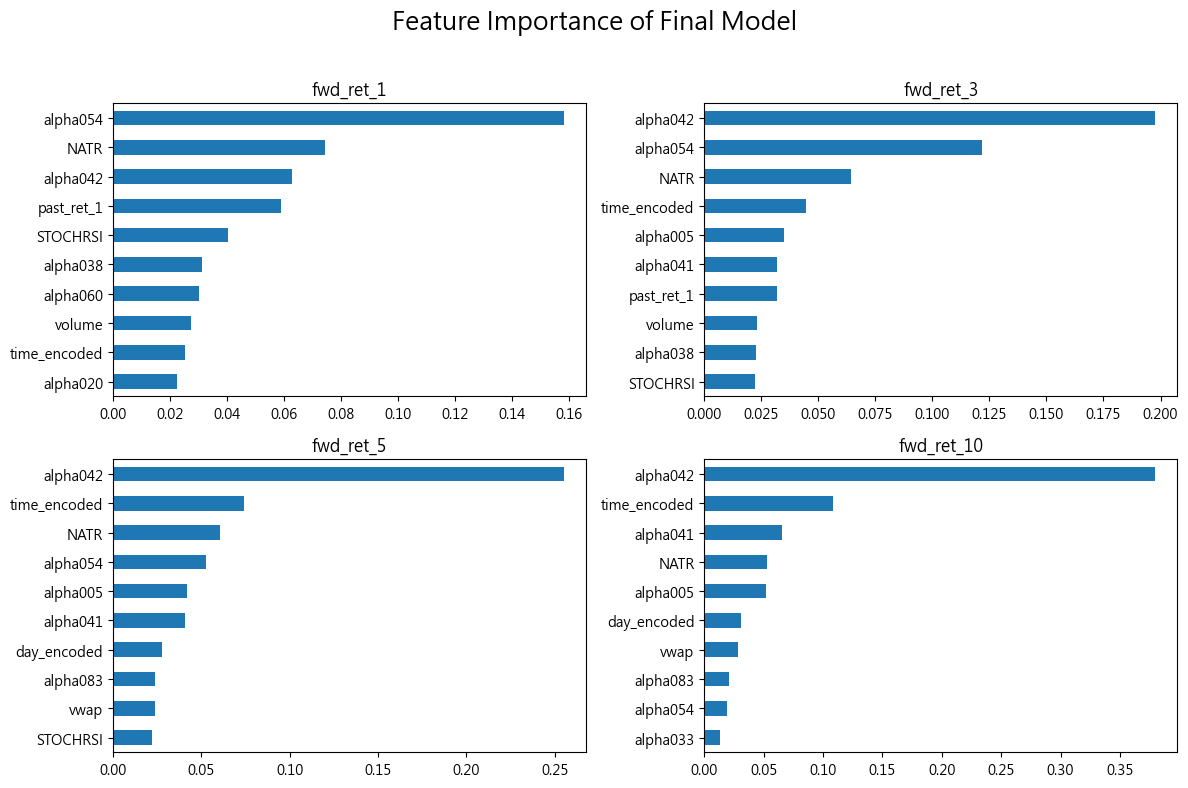

In [24]:
### fi bar plot

num_plots = len(ret_col)
fig, axes = plt.subplots(nrows=int(num_plots/2) , ncols=2, figsize=(12, 2 * num_plots))
                         
for idx, target in enumerate(ret_col):
    row, col = divmod(idx, 2)
    test_res[target]['all_fi'].sort_values(ascending=True).tail(10).\
        plot(kind='barh', title=f"{target}", ax = axes[row, col])

fig.suptitle('Feature Importance of Final Model', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# target = ret_col[0] # fwd_ret_1
# yy = test_res[target]['preds'].copy()
# K = 12
# by_minute = yy.groupby(yy.index.get_level_values('date'), group_keys=False)
# yy['decile'] = by_minute.apply(lambda x: pd.qcut(x.pred, q=K, labels=list(range(1,K+1)), duplicates='raise').astype(int))
# def compute_intraday_returns_by_quantile(predictions, quantile='quintile'):
#     by_quantile = yy.reset_index().groupby(['date', quantile])
#     return by_quantile[target].mean().unstack(quantile).sort_index()   # 同時間不同ticker取mean

# intraday_returns = compute_intraday_returns_by_quantile(yy, quantile='decile')

# (intraday_returns.sort_index().add(1).sub(0.2/10000).cumprod().sub(1)).plot()

### SHAP Feature Importance

C:\Users\h2407\AppData\Local\Temp\ipykernel_5180\169285739.py:4: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



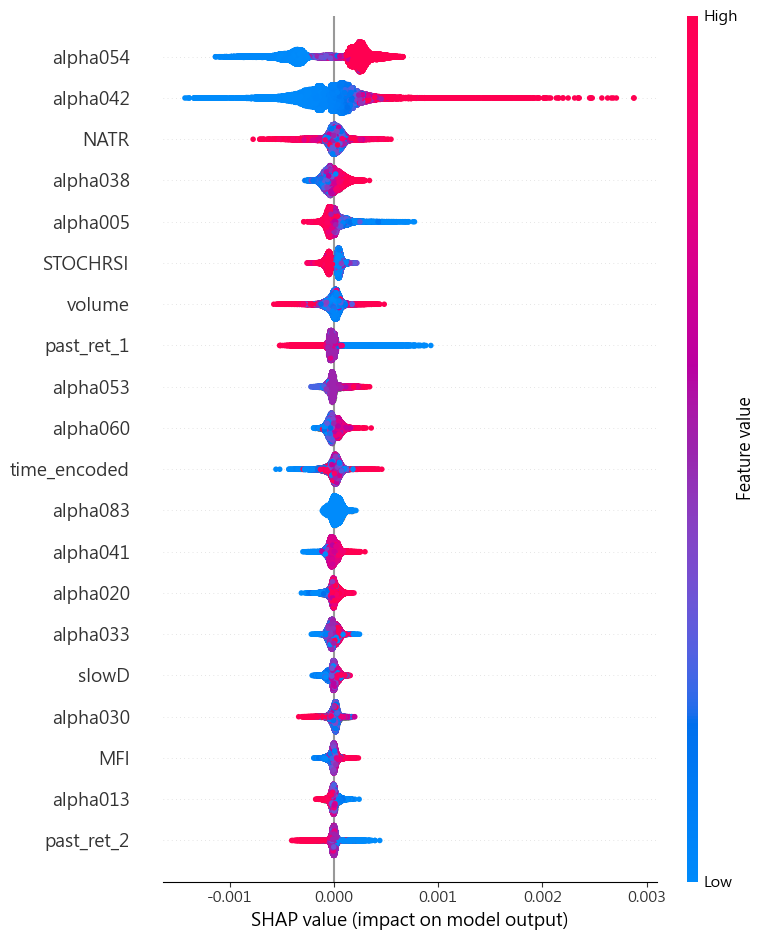

In [939]:
### SHAP fi plot
explainer = shap.TreeExplainer(test_model['fwd_ret_1'])
shap_values = explainer.shap_values(stocks1_test.drop(ret_col, axis=1) )
shap.summary_plot(shap_values, stocks1_test.drop(ret_col, axis=1))

C:\Users\h2407\AppData\Local\Temp\ipykernel_5180\898080938.py:4: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



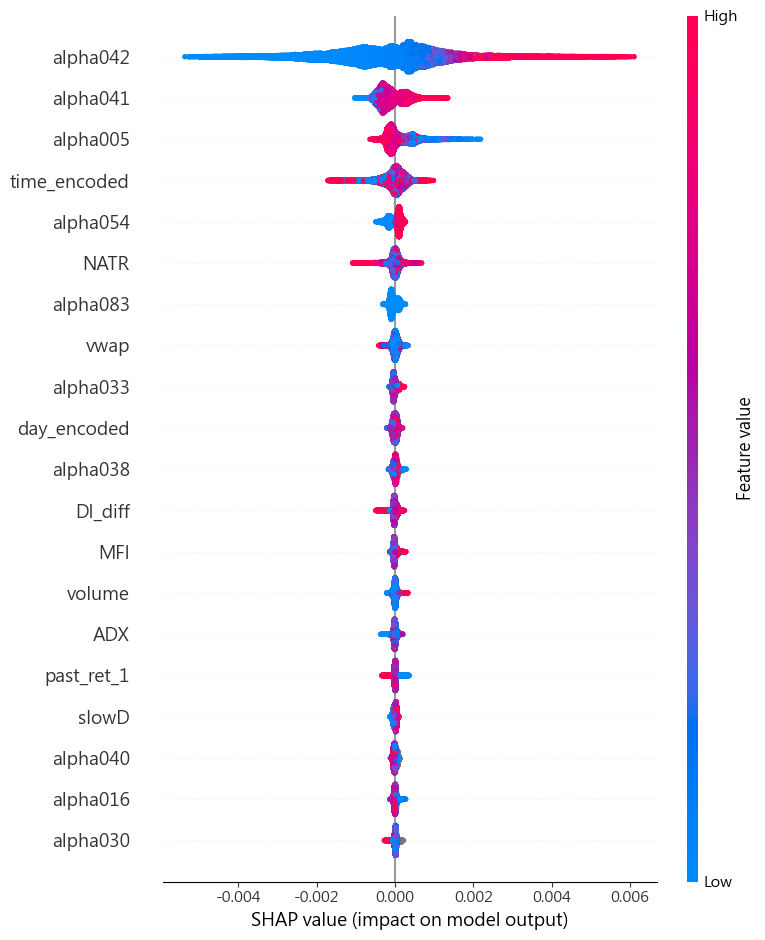

In [940]:
### SHAP fi plot (fwd_ret_10)
explainer = shap.TreeExplainer(test_model['fwd_ret_10'])
shap_values = explainer.shap_values(stocks1_test.drop(ret_col, axis=1) )
shap.summary_plot(shap_values, stocks1_test.drop(ret_col, axis=1))

### Forward Returns Forecasting

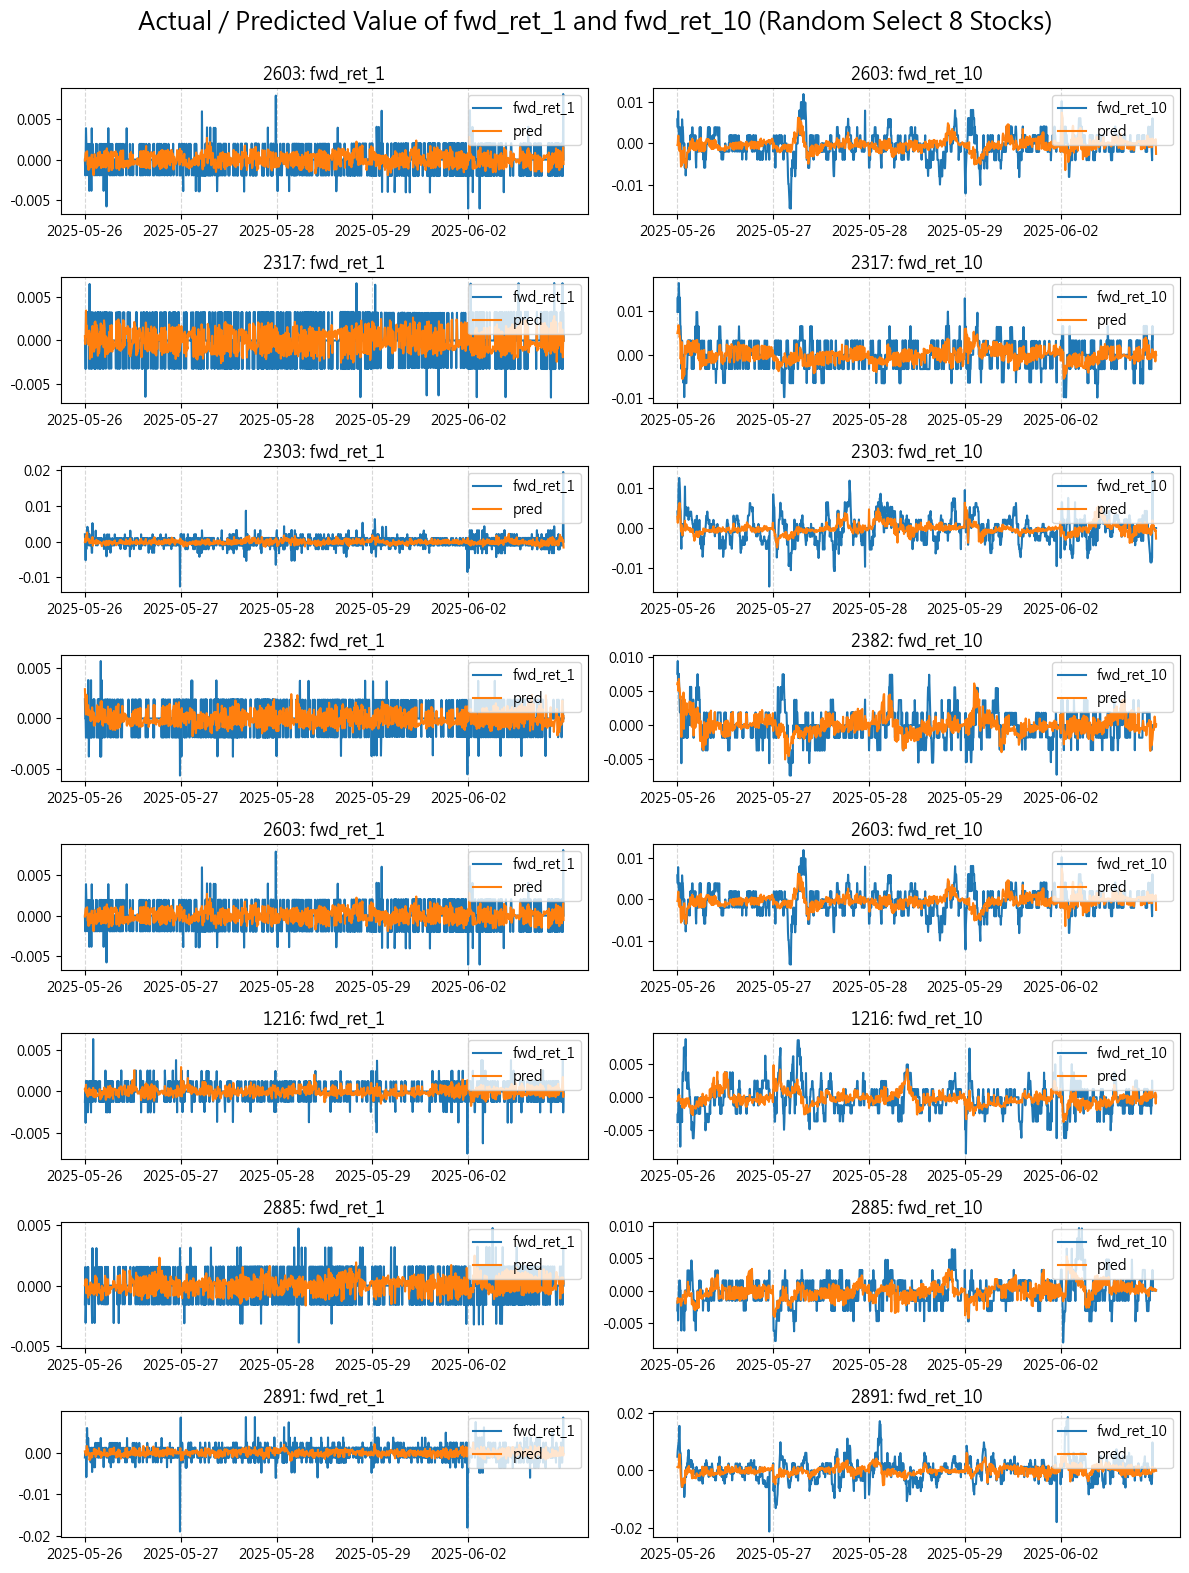

In [25]:
np.random.seed(320)
n = 8
# tickers_random = random.sample(tickers, n)
tickers_random = np.random.choice(tickers, n)
targets = ['fwd_ret_1', 'fwd_ret_10']
fig, axes = plt.subplots(nrows = n , ncols = len(targets) , figsize=(6 * len(targets), 2 * n))

for i, ticker in enumerate(tickers_random):
    for idx, target in enumerate(targets):
        row = i
        col = idx % len(targets)

        preds_ticker=test_res[target]['preds'].query(f"ticker=='{ticker}'").copy().reset_index(level=1, drop=True)
        first_of_day = preds_ticker.groupby(preds_ticker.index.date).head(1).index
        first_of_day_idxnum = preds_ticker.index.get_indexer(first_of_day)
        first_of_day_label = preds_ticker.index[first_of_day_idxnum].date
        preds_ticker.reset_index(drop=True, inplace=True)

        plott = preds_ticker.plot(title = f'{ticker}: {target}', ax = axes[row, col])
        plott.set_xticks(first_of_day_idxnum)
        plott.set_xticklabels(first_of_day_label)
        plott.legend(loc = 'upper right')
        plott.grid(True, axis='x', linestyle='--', alpha=0.5)
    
fig.suptitle(f'Actual / Predicted Value of fwd_ret_1 and fwd_ret_10 (Random Select {n} Stocks)', fontsize=18)
plt.tight_layout(rect = [0,0,1,0.98])
plt.show()


### Box Plots of Actual / Predicted forward Returns

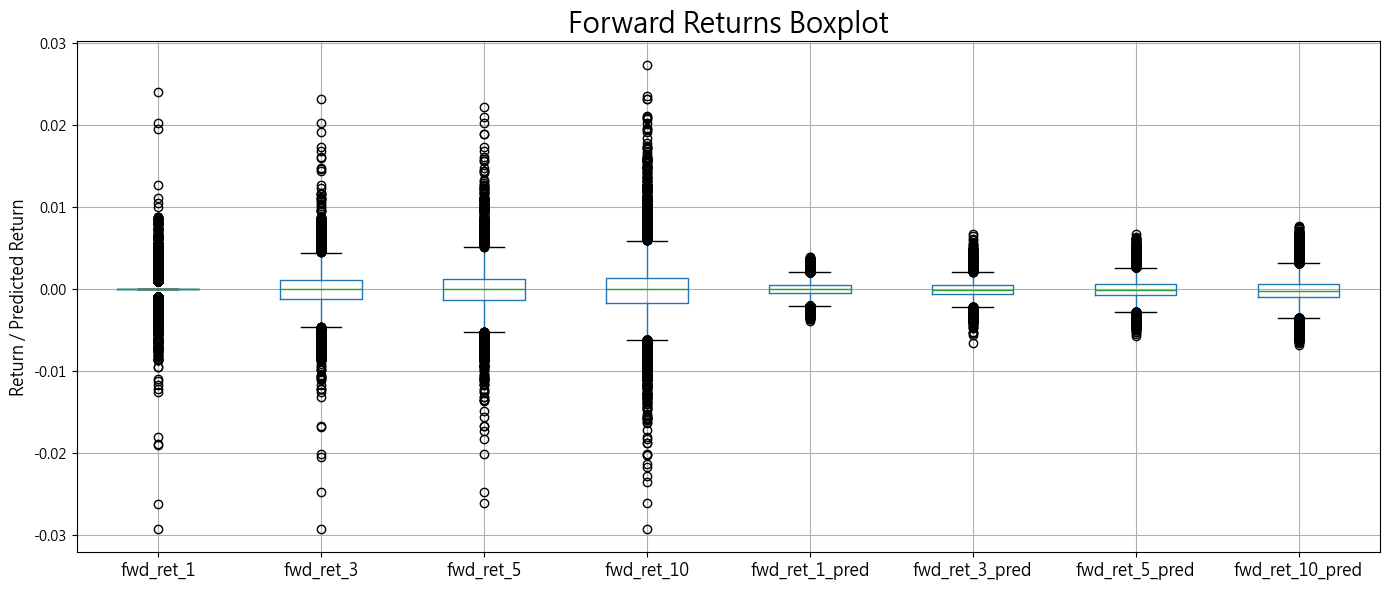

In [26]:
# reload test data
stocks1_test = get_cv(DATA=stocks1).get_test_data().copy()

# 將預測結果與測試集合併
for target in ret_col:
    stocks1_test.loc[:,f'{target}_pred'] = test_res[target]['preds']['pred'].reindex(stocks1_test.index)  

ret_col2 = stocks1_test.filter(regex='fwd_ret').columns  # 未來報酬率+預測的未來報酬率column

# 繪製未來報酬率與其預測值的Box Plot
plt.figure(figsize=(14, 6))  

stocks1_test[ret_col2].boxplot()

# 調整 X 軸文字角度與大小
plt.xticks(rotation=0, fontsize=12)

# 調整標題與座標軸字體大小
plt.title("Forward Returns Boxplot", fontsize=20)
plt.ylabel("Return / Predicted Return", fontsize=12)

plt.tight_layout()
plt.show()

## Backtesting

- Built trading strategies using both the `from_signals` and `from_order_func` methods from the `vectorbt.Portfolio` module.

- The backtesting primarily rely on the predicted future returns, with past returns and technical indicators used as supporting signals.

In [27]:
stocks1_test.head()

open    high     low   close  volume        vwap  \
date                ticker                                                      
2025-05-26 09:00:00 1216     79.9   79.90   79.70   79.70   223.0   79.766667   
                    2207    621.0  622.00  621.00  621.00    12.0  621.333333   
                    2303     47.8   48.05   47.65   48.05  3064.0   47.916667   
                    2308    374.0  374.00  371.00  372.00   116.0  372.333333   
                    2317    152.5  153.00  151.50  152.00  1782.0  152.166667   

                            alpha002  alpha003  alpha005  alpha006  ...  \
date                ticker                                          ...   
2025-05-26 09:00:00 1216         0.0       0.0 -0.729323       0.0  ...   
                    2207         0.0       0.0 -0.180451       0.0  ...   
                    2303         0.0       0.0 -0.601504       0.0  ...   
                    2308         0.0       0.0 -0.703008       0.0  ...   
                    2317         0.0       0.0 -0.033835       0.0  ...   

                                slowK      slowD      NATR        ADX  \
date                ticker                                              
2025-05-26 09:00:00 1216    44.444444  55.555556  0.151297  27.297720   
                    2207    66.666667  73.333333  0.304840  30.755895   
                    2303    26.111111  25.370370  0.257650  46.949989   
                    2308    59.523810  69.841270  0.225562  23.587404   
                    2317    56.666667  63.333333  0.460529  49.666054   

                              DI_diff      OBV  fwd_ret_1_pred  \
date                ticker                                       
2025-05-26 09:00:00 1216   -11.071725  12880.0        0.000318   
                    2207   -23.695994    318.0        0.003005   
                    2303   -52.260905  98439.0       -0.000113   
                    2308   -17.271014  15351.0        0.000631   
                    2317   -31.496645  41279.0        0.000501   

                            fwd_ret_3_pred  fwd_ret_5_pred  fwd_ret_10_pred  
date                ticker                                                   
2025-05-26 09:00:00 1216          0.001219        0.000170        -0.000565  
                    2207          0.005175        0.004826         0.006133  
                    2303          0.000682        0.000992         0.002822  
                    2308          0.001634        0.001297         0.001698  
                    2317          0.001374        0.004101         0.004962  

[5 rows x 70 columns]

In [28]:
stocks1_test.columns  

Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'alpha002',
       'alpha003', 'alpha005', 'alpha006', 'alpha007', 'alpha011', 'alpha012',
       'alpha013', 'alpha015', 'alpha016', 'alpha018', 'alpha020', 'alpha027',
       'alpha030', 'alpha033', 'alpha038', 'alpha040', 'alpha041', 'alpha042',
       'alpha044', 'alpha050', 'alpha051', 'alpha053', 'alpha054', 'alpha060',
       'alpha083', 'alpha101', 'day', 'time', 'stock_encoded', 'day_encoded',
       'time_encoded', 'close_10min', 'close_20min', 'open_10min',
       'open_20min', 'past_ret_1', 'past_ret_2', 'past_ret_3', 'past_ret_4',
       'past_ret_5', 'past_ret_6', 'past_ret_7', 'past_ret_8', 'past_ret_9',
       'past_ret_10', 'fwd_ret_1', 'fwd_ret_3', 'fwd_ret_5', 'fwd_ret_10',
       'BOP', 'CCI', 'MFI', 'STOCHRSI', 'slowK', 'slowD', 'NATR', 'ADX',
       'DI_diff', 'OBV', 'fwd_ret_1_pred', 'fwd_ret_3_pred', 'fwd_ret_5_pred',
       'fwd_ret_10_pred'],
      dtype='object')

### from_signals

#### Strategy Design

- 訊號來源： 僅依賴「預測未來報酬率」（fwd_ret_t_pred，其中 t 為未來 t 分鐘）作為進出場依據，不使用其他複雜訊號或技術指標。

- 資金權重配置： 以各股票當下的 **VWAP（成交量加權平均價）**進行L1正規化，作為資金配置比例。→ 此設計使最終下單股數大致均分。

- 倉位調整邏輯：

    - 進場條件： **fwd_ret_10_pred > 0.1%** 或 **fwd_ret_5_pred > 0.2%**

    - 出場條件： **fwd_ret_10_pred < 0.2%**

- 風控機制：

    - 停損門檻為 **2%**

    - 若部位價格自最高點回落超過 2%，即觸發停損

    - 不設停利條件，讓獲利持續延伸

- 資金與交易限制： 

    - 全部股票共用資金池，並**允許部分下單**，提高資金使用效率。

    - 僅允許**整數股數**下單，單筆下單最少 1 股，最多 2,000 股

    - 初始資金： 1,000,000 元

    - 手續費：每筆交易 **0.1425%**

    - 滑價：每筆交易另計 **0.1%** 滑價





#### Setting

In [29]:
# stocks1_test 已經是 MultiIndex (date, stock)，close 為收盤價
df = stocks1_test.copy()

close = df['close'].unstack()
pred5 = df['fwd_ret_5_pred'].unstack()
pred10 = df['fwd_ret_10_pred'].unstack()

# 進場訊號條件（buy / sell）
buy_signal = (pred10 > 0.001)| (pred5>0.002)#| (pred3.gt(pred5).gt(pred10))# #| (pred3.gt(pred5).gt(pred10))# & (close < bb_lower)
sell_signal = (pred10 < -0.002)# | (pred10.lt(pred5).lt(pred3).lt(0))# # | (pred10.lt(pred5).lt(pred3).lt(0)) #& (close > bb_upper)

INIT_CASH = 1_000_000

# 權重
# weight = (df['alpha042'].unstack() / df['close'].unstack()).transform(lambda x: x/sum(x), axis=1)

# # VWAP 權重 (normalized)
weight = (df['vwap'].unstack()).transform(lambda x: x/sum(x), axis=1).fillna(0)

position_amount = INIT_CASH * weight / close  # 每格股數配置（大致均分）

# position_amount

In [30]:
# 建立 Portfolio
pf_signal = vbt.Portfolio.from_signals(
    close,
    entries=buy_signal,  # 轉為 numpy 給 numba
    exits=sell_signal,
    size=position_amount ,
    # size=vwap_weight,
    init_cash=INIT_CASH,
    freq='1min',
    cash_sharing=True,  # 啟用資金共享
    call_seq='reversed',  # 叫價序列類型（auto-自動決定；random-隨機；default-買方優先；reversed-賣方優先）
    accumulate=True,  # 已有持倉的情況下是否累積（False-訊號不可累積，True-可加碼累積及部分平倉）
    allow_partial=True, # 是否允許部分資金下單
    sl_stop=0.02,  # 停損比例（跌超過多少比例就平倉）
    sl_trail=True,  # 移動停損（最高點回落就平倉停損）
    fees=0.001425,  # 手續費
    slippage=0.001,  # 滑價比例（實際成交價與理想間的差異）
    upon_opposite_entry='close',  # 遇到相反信號時關閉持倉
    size_type="Amount", 
    # size_type='Percent',
    # Amount:固定股數；Value：投入金額；Percent：投入金額的比例（隨總額變化）；TargetPercent (from_order才可用)：讓標的的金額比例在隨著時間變化時平衡回目標比例
    min_size=1,  # 最小交易單位
    max_size=2000,
    size_granularity=1,  # 交易單位間隔
    direction="longonly",
    group_by=True,
    update_value=True,  # 總資金是否隨時更新，預設就是True，但對size_type="value"沒用（因為已事先決定投入金額）
    # tp_stop=0.05,
)

# 若以vwap當標的，size選擇value，則投入股數會是vwap_weight * init_cash /close，但即便收益增加，分配到的金額還是會一樣
# 若size選擇percent，則投入股數會是vwap_weight * "remain_cash" /close ，因此訂單愈晚處理分配到的金額愈少
# BBANDS因高頻標準差較不准不太適合、RSI要搭配成交量使用比較適合

# HFT: 交易頻率低、交易量大、分批進出場、寬鬆止盈止損、提高勝率(最重要!!!)
# 想法：限制最小成交量/價（以降低次數）、最小持倉時間(可能有好有壞?)、思考延遲的部分（maybe跟滑價選一個就好）
# maybe開收盤的進出場條件設不一樣可以優化

# 我希望from_order_func能做到的：
## 1. 開收盤條件強化（進場條件較嚴格，收盤可考慮）
## 2. 根據更多條件設定加碼、停損出場
## 3. 務必做到隨時按收益調整總資金及各成分股的投入金額（比例）
## 3-1 每個時間點調整一次並且"不要"像size_type='percent'那樣同個時間點先處理股票號碼小的以致權重失衡
## 4. 棄用vwap作為投資組合權重，還沒想到適合的，maybe用close、等權、預期報酬率加權

#### Table Results

In [31]:
pf_signal.stats()

Start                               2025-05-26 09:00:00
End                                 2025-06-02 13:30:00
Period                                  0 days 22:10:00
Start Value                                   1000000.0
End Value                                1072980.401678
Total Return [%]                                7.29804
Benchmark Return [%]                           -1.89655
Max Gross Exposure [%]                        99.999998
Total Fees Paid                            45217.388772
Max Drawdown [%]                               1.451461
Max Drawdown Duration                   0 days 05:09:00
Total Trades                                        858
Total Closed Trades                                 839
Total Open Trades                                    19
Open Trade PnL                             10099.947901
Win Rate [%]                                  56.853397
Best Trade [%]                                 2.402555
Worst Trade [%]                               -4

In [32]:
print(f"Alpha: {pf_signal.alpha():.3e}, \nBeta: {pf_signal.beta():.4}")
# portfolio.asset_flow().loc[portfolio.asset_flow().apply(sum, axis=1)!=0]
# pf_signal.positions.values

Alpha: 4.005e+15, 
Beta: 1.05


In [33]:
# 各檔個股下單次數
pf_signal.orders.records_readable.query('Side=="Buy"').groupby('Column').size()

Column
1216     47
2207     36
2303     59
2308     33
2317     67
2330     10
2345     29
2357     34
2382     53
2412    117
2454     93
2603     28
2880     35
2881     72
2882     88
2884     59
2885     54
2886     67
2891     92
2892    135
3045    118
3711     58
5880     52
6505     68
6669     38
dtype: int64

In [34]:
# 各檔個股出場次數

pf_signal.orders.records_readable.query('Side=="Sell"').groupby('Column').size()

Column
1216    29
2207    17
2303    28
2308    21
2317    31
2330     6
2345    14
2357    18
2382    31
2412    77
2454    37
2603    14
2880    19
2881    30
2882    62
2884    23
2885    18
2886    51
2891    54
2892    62
3045    93
3711    33
5880    22
6505    33
6669    16
dtype: int64

In [35]:
# 模型請求的訂單數據（不一定成交）
# pf_signal.asset_flow()
pf_signal.orders.records_readable.sort_values(by=['Column', 'Timestamp'], ascending=True)

Order Id Column           Timestamp   Size      Price       Fees  Side
253        253   1216 2025-05-26 11:18:00  117.0    78.8788  13.151068   Buy
260        260   1216 2025-05-26 11:19:00  117.0    78.8788  13.151068   Buy
267        267   1216 2025-05-26 11:20:00  117.0    78.8788  13.151068   Buy
273        273   1216 2025-05-26 11:21:00  117.0    78.8788  13.151068   Buy
334        334   1216 2025-05-27 09:01:00  116.0    80.1801  13.253771   Buy
...        ...    ...                 ...    ...        ...        ...   ...
2136      2136   6669 2025-06-02 10:14:00    3.0  2392.3900  10.227467   Buy
2162      2162   6669 2025-06-02 10:22:00    3.0  2407.5900  10.292447  Sell
2290      2290   6669 2025-06-02 12:26:00    2.0  2387.3850   6.804047   Buy
2297      2297   6669 2025-06-02 12:35:00    6.0  2392.3900  20.454935   Buy
2316      2316   6669 2025-06-02 12:42:00    6.0  2392.3900  20.454935   Buy

[2381 rows x 7 columns]

In [36]:
# 實際成交的訂單數據（entry time跟exit time分別代表該訂單最早入倉的時間以及最晚清空倉位的時間）

# pf_signal.asset_flow()
pf_signal.trades.records_readable.sort_values(by=['Column', 'Entry Timestamp'], ascending=True)

Exit Trade Id Column   Size     Entry Timestamp  Avg Entry Price  \
0                0   1216  115.0 2025-05-26 11:18:00        80.021136   
1                1   1216  115.0 2025-05-26 11:18:00        80.021136   
2                2   1216  115.0 2025-05-26 11:18:00        80.021136   
3                3   1216  115.0 2025-05-26 11:18:00        80.021136   
4                4   1216  115.0 2025-05-26 11:18:00        80.021136   
..             ...    ...    ...                 ...              ...   
853            853   6669   16.0 2025-05-29 12:00:00      2447.445000   
854            854   6669  115.0 2025-06-02 09:01:00      2377.375000   
855            855   6669   38.0 2025-06-02 09:01:00      2377.375000   
856            856   6669    3.0 2025-06-02 10:14:00      2392.390000   
857            857   6669   14.0 2025-06-02 12:26:00      2391.675000   

     Entry Fees      Exit Timestamp  Avg Exit Price   Exit Fees          PnL  \
0     13.113464 2025-05-27 10:26:00         81.5184   13.358828   145.713113   
1     13.113464 2025-05-27 10:27:00         81.5184   13.358828   145.713113   
2     13.113464 2025-05-27 10:28:00         81.5184   13.358828   145.713113   
3     13.113464 2025-05-27 10:29:00         81.5184   13.358828   145.713113   
4     13.113464 2025-05-27 10:30:00         81.5184   13.358828   145.713113   
..          ...                 ...             ...         ...          ...   
853   55.801746 2025-06-02 09:00:00       2395.0000   54.606000  -949.527746   
854  389.592328 2025-06-02 09:07:00       2417.5800  396.180923  3837.801749   
855  128.734856 2025-06-02 09:08:00       2427.5700  131.452916  1647.222228   
856   10.227467 2025-06-02 10:22:00       2407.5900   10.292447    25.080086   
857   47.713916 2025-06-02 13:30:00       2410.0000    0.000000   208.836084   

       Return Direction  Status  Position Id  
0    0.015834      Long  Closed            0  
1    0.015834      Long  Closed            0  
2    0.015834      Long  Closed            0  
3    0.015834      Long  Closed            0  
4    0.015834      Long  Closed            0  
..        ...       ...     ...          ...  
853 -0.024248      Long  Closed          221  
854  0.014037      Long  Closed          222  
855  0.018234      Long  Closed          222  
856  0.003494      Long  Closed          223  
857  0.006237      Long    Open          224  

[858 rows x 14 columns]

#### Figure Results

In [37]:
datetime_order = pf_signal.wrapper.index
ticker_order = pf_signal.wrapper.columns

# 將圖片的x軸還原成原始資料日期（非交易時間不留白）
def fig_adj_xaxis(fig):
    first_of_day = [dt[0] for dt in datetime_order.groupby(datetime_order.date).values()]
    fig.update_layout(
        xaxis_type='category',
        xaxis=dict(tickmode='array',
                   tickvals=[datetime_order.get_loc(dt) for dt in first_of_day], 
                   ticktext=[dt.strftime('%Y-%m-%d') for dt in first_of_day], 
                   tickangle=0)
    )
    return fig.show()

def fig_adj_xaxis_subplot(fig, subplot_idx):
    first_of_day = [dt[0] for dt in datetime_order.groupby(datetime_order.date).values()]

    xaxis_key = f'xaxis{subplot_idx}' if subplot_idx > 1 else 'xaxis'
    fig.update_layout({
        xaxis_key: dict(
            type='category',
            tickmode='array',
            tickvals=[datetime_order.get_loc(dt) for dt in first_of_day],
            ticktext=[dt.strftime('%Y-%m-%d') for dt in first_of_day],
            tickangle=30
        )
    })

In [38]:
fig = pf_signal.plot_cum_returns(title='Portfolio Cumulative Returns')
fig.update_layout(yaxis_tickformat='.2%')
fig_adj_xaxis(fig)

In [39]:
# 回撤深度（相對歷史高點跌幅）
fig = pf_signal.plot_underwater(title='Portfolio Drawdown')
fig.update_layout(yaxis_tickformat='.2%')
fig_adj_xaxis(fig)

In [40]:
fig = (pf_signal.cash()/pf_signal.value()).vbt.plot(title='Portfolio Cash-to-Equity Ratio')
fig.update_layout(yaxis_tickformat='.2%')
fig_adj_xaxis(fig)

In [41]:
# 個股的部位變化(Position)與訂單進出倉變化(Order)的結果（隨機選取6檔個股）
from plotly.subplots import make_subplots
np.random.seed(320)
n = 6
ticker_chosen = np.random.choice(ticker_order, n, replace=False)
fig = make_subplots(rows=n, cols=2, 
                    horizontal_spacing=0.05,   # 預設 0.2，改小會讓子圖更寬
                    vertical_spacing=0.05,     # 改小會讓子圖更高
                    subplot_titles=sum(
                        [[f'{i} Position', f'{i} Order'] for i in ticker_chosen]
                        , [])  # sum(,[])是把nested list unnest
                    )

# 旗標：只顯示一次圖例
legend_shown = False

for row, ticker in enumerate(ticker_chosen):
    for col, data_type in enumerate(['positions', 'orders']):
        
        if data_type == 'positions':
            subfig = pf_signal.positions.plot(ticker)
        else:
            subfig = pf_signal.orders.plot(ticker)

        subplot_idx = row * 2 + col + 1

        # 設定 subplot 對應的 xref/yref 名稱
        xref = f'x{subplot_idx if subplot_idx > 1 else ""}'
        yref = f'y{subplot_idx if subplot_idx > 1 else ""}'

        for trace in subfig.data:
            # 只保留第一次圖例，其餘關掉
            trace.showlegend = not legend_shown
            fig.add_trace(trace, row=row+1, col=col+1)

        legend_shown = True  # 之後就不再顯示圖例        

        # 加入該子圖的所有 shape（如果有）
        if 'shapes' in subfig.layout:
            for shape in subfig.layout.shapes:
                # shape = shape.copy()  # 避免修改原物件
                shape['xref'] = xref
                shape['yref'] = yref
                fig.add_shape(shape, row=row+1, col=col+1)    
        
        fig_adj_xaxis_subplot(fig, subplot_idx)

# 調整 legend 到圖的上方
fig.update_layout(
    title = dict(
        text=f"Position and Order Flow (Randomly Selected {n} Stocks)",
        x=0.5,  # 水平置中
        xanchor='center',
        font=dict(size=20)
    ),
    margin = dict(t=150),
    height=300*n,
    width=1100,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

fig.show()


### from_order_func

#### Strategy Design

- 主要目標：
    - 彌補 from_signals 無法支援加碼／減碼的限制，**明確設計出倉位調整（加碼、減碼）、停利與停損的邏輯**。

- 次要目標：
    - 提升勝率、總報酬率與 Sharpe ratio，同時減少不必要的進出場，以降低手續費成本。

- 資金權重配置：
    
    - 以各股票當下的 **VWAP × Alpha42** 值進行 L1 正規化，作為資金配置比例。

    - 註：Alpha42 是基於 LightGBM 模型預測未來報酬率中，最重要的因子。

- 倉位調整邏輯：

    - 進場訊號（無持倉時）：
        - **fwd_ret_10_pred > 0.1%**
        - **fwd_ret_5_pred > 0.2%** 
        - 任一滿足 → 建倉 80%；兩者皆滿足 → 建倉 120%（允許超過 100% 以充分利用資金）

    - 加碼訊號：
        - 訊號1：
            - **fwd_ret_10_pred > 0.05%** 
            - **過去30分鐘報酬率 > -1%**
            - 全部滿足 → 增倉 20%

        - 訊號2：
            - **fwd_ret_10_pred > 0.08%** 
            - **fwd_ret_5_pred > 0.2%** 
            - 任一滿足 → 增倉 20%；兩者皆滿足 → 增倉 50%

    - 停損訊號：
        - **當前持倉淨損益（扣成本後報酬） < -2%**
        - **過去5分鐘報酬 < -1.5%**
        - **過去10分鐘報酬 < -2%**
        - **過去30分鐘報酬 < -4%**
        - **NATR（正則化平均真實波動）> 0.25**
        - **當前收盤價 / EMA10（10分鐘指數平滑移動平均）∈ (0.98, 1.01)**
        - 滿足 3~4 項 → 減倉 40%； 5~6 項 → 減倉 60%

    - 停利訊號：
        - **當前持倉淨損益 > 0.5%**  →  減倉30%
        - **當前持倉淨損益 > 1.5%**  →  減倉80%

    - 全部出場訊號：
        - **過去5分鐘報酬 < -0.15%**
        - **過去10分鐘報酬 < -0.2%**
        - **當前持倉已回本**
        - **距離首次建倉（當前持倉最早入場）時間超過60分鐘**
        - 距離首次建倉已超過20分鐘時，且滿足任3項以上 → 全部平倉

- 資金與交易限制： 

    - 全部股票共用資金池，並**允許部分下單**，提高資金使用效率。

    - 僅允許**整數股數**下單，單筆下單最少 1 股，最多 2,000 股

    - 初始資金： 1,000,000 元

    - 手續費：每筆交易 **0.1425%**

    - 滑價：每筆交易另計 **0.1%** 滑價

#### Setting

In [42]:
# plt.figure(figsize=(18,6))
# i=20
# p1=stocks1_test.xs(stocks1_test['open'].unstack().columns[i], level='ticker').reset_index(drop=True)[['close']].plot(kind="line", ax=plt.gca())
# p2=stocks1_test['close'].unstack().apply(lambda x: ta.EMA(x, timeperiod=10), axis=0).iloc[:,i].reset_index(drop=True).plot(ax=plt.gca())
# p3=stocks1_test['close'].unstack().apply(lambda x: ta.EMA(x, timeperiod=30), axis=0).iloc[:,i].reset_index(drop=True).plot(ax=plt.gca())
# p4=(vbt.RSI.run(stocks1_test['close'].unstack().reset_index(drop=True), window=30).rsi.iloc[:,0]).plot(secondary_y=True, ax=plt.gca())
# p5=(vbt.MA.run(close, window=10).ma.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p6=(vbt.MA.run(close, window=60).ma.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p7=(vbt.BBANDS.run(stocks1_test['close'].unstack().reset_index(drop=True), window=15).lower.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p8=(vbt.BBANDS.run(stocks1_test['close'].unstack().reset_index(drop=True), window=60).upper.iloc[:,i]).plot(secondary_y=True, ax=plt.gca())
# p9=stocks1_test['NATR'].unstack().reset_index(drop=True).iloc[:,i].plot(secondary_y=True, ax=plt.gca())
# plt.show()

In [43]:
import numba
from numba import njit
from vectorbt.portfolio import nb as portfolio_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [44]:
@njit
def order_func_nb(c, # context，可用屬性要看github enums.OrderContext https://github.com/polakowo/vectorbt/blob/master/vectorbt/portfolio/enums.py
                  pred1_, pred3_, pred5_, pred10_, pastret5_, pastret10_, pastret30_, weight_, natr_, cummax_close, ema10_,
                  SIZE_TYPE, DIRECTION, FEES, FIXED_FEES, SLIPPAGE, 
                  MIN_SIZE, MAX_SIZE, MAX_ENTRY_AMOUNT_RATIO, MAX_EXIT_AMOUNT_RATIO):

    # price = close_[c.i, c.col]
    price = c.close[c.i, c.col]
    # cummax_price = cummax_close[c.i, c.col]
    pastret5 = pastret5_[c.i, c.col]
    pastret10 = pastret10_[c.i, c.col]
    pastret30 = pastret30_[c.i, c.col]
    pred5 = pred5_[c.i, c.col]
    pred10 = pred10_[c.i, c.col]
    w = weight_[c.i, c.col]
    natr = natr_[c.i, c.col]
    ema10 = ema10_[c.i, c.col]

    # c.value_now: 目前價值
    # c.cash_now: 目前現金
    # c.position_now: 目前持有部位
    # c.return_now: 目前整個組合的收益
    # c.pos_record_now 前一筆完整進出場紀錄 
    # (0: position_id, 1: col, 2: size, 3: entry_time_idx, 4: entry_price, 5: entry_fees, 
    # 6: exit_time_idx, 7: exit_price, 8:exit_fees, 9: pnl, 10: return, 11: direction, 12: status, 13: position id 該檔第幾筆訂單)
    # (direction, status): (0,0):持買倉未平，(0,1):持買倉已平，(1,0):持賣倉未平，(1,1):持賣倉已平

    # c.last_oidx[c.col] 前一筆交易id
    # c.last_val_price[c.col] # 上次執行價格（買入賣出價）
    # c.order_records[c.last_oidx[c.col]] 前一筆交易紀錄 
    # (0: 交易id, 1: col, 2: time_idx, 3: size, 4: price(含滑價), 5: 總費用, 6: 買入0還是賣出1)

    curr_pos = c.position_now  # 目前持倉數
    curr_pos_cost = c.last_val_price[c.col] * (1 + FEES + FIXED_FEES)   # 前一次入場的每股成本
    curr_pos_ret = price / curr_pos_cost - 1
    # curr_ret_from_max = price / cummax_price - 1 # 價格自高點回落比例
    last_entry_time = c.pos_record_now[3]  # 前一次進場時間（若Accumulate=F或設定只有當curr_pos == 0才入場，則兩次交易之方向必相反）
    last_exit_time = c.pos_record_now[6]   # 前一次出場時間
    time_from_last_entry = c.i - last_entry_time
    time_from_last_exit = c.i - last_exit_time
    

    size = 0  # 未滿足以下倉位調整的條件即不進行操作

    # ###### 此區以下為仿from_signals的策略邏輯 ######
    # exit_signal = (pred10<-0.002) + (curr_pos_ret < -0.02) + (0.98 < price /ema10 < 1.01)
    # if curr_pos > 0:
    #     if exit_signal >= 2: # 滿足訊號任2個以上
    #         size = -curr_pos
    
    # if (pred10>0.001) or (pred5>0.002):
    #         size = np.round(c.cash_now * w / price)
    # ###### 此區以上為from_signals的策略邏輯 ######     


    # #### 出場邏輯 #### (先出場再入場)
    if curr_pos > 0:

        sl_signal = (curr_pos_ret < -0.02) + (pastret5 < -0.015) + (pastret10 < -0.02) + (pastret30 < -0.04) + (natr > 0.25) + (0.98 < price /ema10 < 1.01)
        tp_signal1 = (curr_pos_ret > (0.005 + FEES + SLIPPAGE))  # 扣除成本超過1%報酬
        tp_signal2 = (curr_pos_ret > (0.015 + FEES + SLIPPAGE))
        exit_signal = ( (pred5 < -0.0015) +(pred10 < -0.002) + 
                       (curr_pos_ret > (FEES + SLIPPAGE)) +  # 已回本
                        (time_from_last_entry > 60) )  # 至少持倉60分鐘
        
        # 停損：滿足停損訊號(sl_signal)任5件以上，平倉60%；3~4件，平倉40%
        if sl_signal >= 5:
            size = -np.round(curr_pos * 0.6)

        elif sl_signal >= 3: 
            size = -np.round(curr_pos * 0.4)

        # 停利：扣除成本超過1.5%報酬(tp_signal2)，平倉80%，超過1%報酬(tp_signal1)，平倉30%  
        elif tp_signal2:
            size = -np.round(curr_pos * 0.8)

        elif tp_signal1:  
            size = -np.round(curr_pos * 0.3)    
        
        # 全部出倉：至少持倉20分鐘且滿足出倉訊號(exit_signal)任3件以上，全部平倉
        elif (time_from_last_entry > 20) and exit_signal >= 3:  
            size = -curr_pos
        
    # 自訂出場交易股數上限（上限：當前資金*自訂資金上限ratio/收盤價）
    size = max(size, -(c.value_now * MAX_EXIT_AMOUNT_RATIO / price) )  

    # #### 進場邏輯 ####

    add_pos = np.round(c.cash_now * w / price)   # 進場倉位（股數，取整）：每次進場前都更新現有資金(c.cash_now)及權重、收盤價
    entry_signal = (pred10 > 0.001) + (pred5 > 0.002)  # 進場條件
    bonus_signal1 = (pred10 > 0.0005) + (pastret30 >= -0.01) 
    bonus_signal2 = (pred10 > 0.0008) + (pred5 > 0.0012)

    # 進場（此時間點之前未有倉位）：滿足所有進場訊號(entry signal)，入倉120%（為使資金充分利用因此超過100%），只滿足其中1件，入倉80%
    if curr_pos == 0:
        if entry_signal == 2:  
            size = np.round(add_pos * 1.2)  

        elif entry_signal==1:
            size = np.round(add_pos * 0.8)

    # 加碼條件1: 滿足加碼訊號1(bonus_signal1)全部符合，增倉20%
    elif bonus_signal1 == 2:   
        size = np.round(add_pos * 0.2)

    # 加碼條件2: 滿足加碼訊號2(bonus_signal2)全部符合，增倉50%，只滿足1件，增倉20%
    elif bonus_signal2 == 2:
        size = np.round(add_pos * 0.5)
    
    elif bonus_signal2 == 1:
        size = np.round(add_pos * 0.2)

    # 自訂進場交易股數上限（上限：當前資金*自訂資金上限ratio/收盤價）
    size = min(size, (c.value_now * MAX_ENTRY_AMOUNT_RATIO / price))  

    
    return portfolio_nb.order_nb(
        size=size,
        price=price,
        size_type=SIZE_TYPE, # Amount:固定股數；Value：投入金額；Percent：投入金額的比例（隨總額變化）；TargetPercent：讓標的的金額比例在隨著時間變化時平衡回目標比例
        direction=DIRECTION, 
        fees=FEES,
        fixed_fees=FIXED_FEES,
        slippage=SLIPPAGE,
        min_size=MIN_SIZE,
        size_granularity=1,  # 單位為1股
        max_size=MAX_SIZE,   # 限制每個時間點每支個股的交易股數上限（進出場皆限制）
        reject_prob=0.0,
        allow_partial=True,  # 是否允許部分資金投入（當資金不足時）
        raise_reject=False,  # 異常時是否需要中止
        log=True
    )


In [45]:
df = stocks1_test.copy()

# open = df['open'].unstack().values
close = df['close'].unstack().values
cummax_close = df['close'].unstack().cummax().values
# vwap = df['vwap'].unstack().values
# volume = df['volume'].unstack().values
pastret5 = df['past_ret_5'].unstack().values
pastret10 = df['past_ret_10'].unstack().values
pastret30 = df['close'].unstack().transform(lambda x: x.pct_change(periods=30)).values
pred1 = df['fwd_ret_1_pred'].unstack().values
pred3 = df['fwd_ret_3_pred'].unstack().values
pred5 = df['fwd_ret_5_pred'].unstack().values
pred10 = df['fwd_ret_10_pred'].unstack().values
natr = df['NATR'].unstack().values
ema10 = df['close'].unstack().apply(lambda x: ta.EMA(x, timeperiod=10), axis=0).values


# 權重設計（如用預測值加權）
# rk_alpha042 = df['alpha042'].groupby('date').rank()
# rk_alpha041 = df['alpha041'].groupby('date').rank()
# minmax_alpha041 = df['alpha041'].unstack().apply(lambda x: (x-min(x))/(max(x)-min(x)), axis=1)
# weight = (( df['alpha042'].unstack() * minmax_alpha041) / df['close'].unstack()).apply(lambda x: x/sum(x), axis=1).values
weight = (df['alpha042'].unstack() * df['vwap'].unstack()).transform(lambda x: x/sum(x), axis=1).values

# weight = (df['vwap'].unstack()).transform(lambda x: x/sum(x), axis=1).values


In [46]:
def simu_vbt_from_order_func(SIZE_TYPE=SizeType.Amount, DIRECTION=Direction.LongOnly, INIT_CASH=1_000_000,
                             FEES=0.001425, FIXED_FEES=0, SLIPPAGE=0.001, 
                             MIN_SIZE=1, MAX_SIZE=np.inf, MAX_ENTRY_AMOUNT_RATIO=1, MAX_EXIT_AMOUNT_RATIO=1):
    
    return vbt.Portfolio.from_order_func(
        close,
        order_func_nb,
        pred1, pred3, pred5, pred10, pastret5, pastret10, pastret30, weight, natr, cummax_close, ema10, # *args for order_func_nb
        SIZE_TYPE, DIRECTION, FEES, FIXED_FEES, SLIPPAGE, 
        MIN_SIZE, MAX_SIZE, MAX_ENTRY_AMOUNT_RATIO, MAX_EXIT_AMOUNT_RATIO,
        init_cash=INIT_CASH,
        cash_sharing=True,
        update_value=True,
        group_by=True,  # 每個時間點視為同一組
        freq='1min'
    )

In [47]:
pf_orderfnb = simu_vbt_from_order_func(MAX_SIZE=2000, MAX_ENTRY_AMOUNT_RATIO=0.15, MAX_EXIT_AMOUNT_RATIO=0.15) # 單次進出場資金流動不得超過總資金15%

#### Table Results

In [48]:
pf_orderfnb.stats()

Start                                                 0
End                                                1329
Period                                  0 days 22:10:00
Start Value                                   1000000.0
End Value                                1103146.030366
Total Return [%]                              10.314603
Benchmark Return [%]                           -1.89655
Max Gross Exposure [%]                        99.989061
Total Fees Paid                            42537.792134
Max Drawdown [%]                               1.418094
Max Drawdown Duration                   0 days 02:36:00
Total Trades                                        301
Total Closed Trades                                 281
Total Open Trades                                    20
Open Trade PnL                              2351.479576
Win Rate [%]                                  61.921708
Best Trade [%]                                 2.800638
Worst Trade [%]                               -4

In [49]:
print(f"Alpha: {pf_orderfnb.alpha():.3e}, \nBeta: {pf_orderfnb.beta():.3}")

Alpha: 8.538e+20, 
Beta: 1.22


In [50]:
pf_orderfnb_orders = pf_orderfnb.orders.records_readable
# 將時間與股票的encoding轉成真實值
pf_orderfnb_orders['Timestamp'] = datetime_order[pf_orderfnb_orders['Timestamp']]
pf_orderfnb_orders['Column'] = ticker_order[pf_orderfnb_orders['Column']]

In [51]:
# 各檔個股下單次數
pf_orderfnb_orders.query('Side=="Buy"').groupby('Column').size()

Column
1216    185
2207    264
2303    168
2308    198
2317    276
2330     92
2345    171
2357    234
2382    164
2412    313
2454    318
2603    184
2880    140
2881    156
2882    266
2884    245
2885    214
2886    308
2891    275
2892    324
3045    352
3711    244
5880    198
6505    171
6669    243
dtype: int64

In [52]:
# 各檔個股出場次數
pf_orderfnb_orders.query('Side=="Sell"').groupby('Column').size()

Column
1216     5
2207    10
2303     8
2308     9
2317    11
2330     8
2345     9
2357    10
2382     8
2412    11
2454    30
2603     8
2880     4
2881     6
2882    11
2884     4
2885     6
2886     8
2891    13
2892    11
3045    30
3711    12
5880     6
6505    20
6669    23
dtype: int64

In [53]:
# 請求的訂單數據（不一定成交）
pf_orderfnb_orders.sort_values(by=['Timestamp'], ascending=True)

Order Id Column           Timestamp   Size       Price        Fees  Side
0            0   2207 2025-05-26 09:00:00  241.0   621.62100  213.480192   Buy
13          13   6669 2025-05-26 09:00:00   65.0  2307.30500  213.714126   Buy
12          12   6505 2025-05-26 09:00:00  104.0    38.98895    5.778162   Buy
11          11   3711 2025-05-26 09:00:00   35.0   142.14200    7.089332   Buy
10          10   3045 2025-05-26 09:00:00  221.0   116.61650   36.725451   Buy
...        ...    ...                 ...    ...         ...         ...   ...
5978      5978   1216 2025-06-02 13:23:00    1.0    78.97890    0.112545   Buy
5980      5980   2454 2025-06-02 13:24:00    1.0  1236.23500    1.761635   Buy
5982      5982   2454 2025-06-02 13:30:00   73.0  1258.74000  130.940429  Sell
5981      5981   2303 2025-06-02 13:30:00    2.0    46.90305    0.133674  Sell
5983      5983   2603 2025-06-02 13:30:00  317.0   246.75300  111.464499  Sell

[5984 rows x 7 columns]

In [54]:
# 實際成交的訂單數據（entry time跟exit time分別代表該訂單最早開始入倉的時間以及最晚清空倉位的時間）

# pf_orderfnb.asset_flow()
pf_orderfnb_trades = pf_orderfnb.trades.records_readable
# entry 和 exit 時間轉成真正的 datetime
pf_orderfnb_trades['Entry Timestamp'] = datetime_order[pf_orderfnb_trades['Entry Timestamp']]
pf_orderfnb_trades['Exit Timestamp'] = datetime_order[pf_orderfnb_trades['Exit Timestamp']]

# 轉回真正的股票代號
pf_orderfnb_trades['Column'] = ticker_order[pf_orderfnb_trades['Column']]

pf_orderfnb_trades.sort_values(by=['Column', 'Entry Timestamp'], ascending=True) #.sort_values(by='PnL', ascending=False)


Exit Trade Id Column    Size     Entry Timestamp  Avg Entry Price  \
0                0   1216  1884.0 2025-05-26 10:30:00        79.804946   
1                1   1216   725.0 2025-05-26 10:30:00        79.804946   
2                2   1216  1441.0 2025-05-27 11:26:00        80.783618   
3                3   1216     6.0 2025-05-28 11:58:00        81.114367   
4                4   1216    88.0 2025-05-29 12:40:00        80.125500   
..             ...    ...     ...                 ...              ...   
296            296   6669     4.0 2025-05-29 09:48:00      2453.084963   
297            297   6669    66.0 2025-05-29 11:59:00      2410.512500   
298            298   6669    66.0 2025-05-29 11:59:00      2410.512500   
299            299   6669    50.0 2025-05-29 11:59:00      2410.512500   
300            300   6669   171.0 2025-06-02 10:04:00      2394.058333   

     Entry Fees      Exit Timestamp  Avg Exit Price   Exit Fees          PnL  \
0    214.252337 2025-05-27 10:26:00         81.5184  218.852448  2795.043282   
1     82.448484 2025-05-27 10:27:00         81.5184   84.218697  1075.587250   
2    165.883100 2025-05-28 11:13:00         81.2187  166.776509   294.294191   
3      0.693528 2025-05-29 09:03:00         81.5184    0.696982     1.033690   
4     10.047738 2025-06-02 09:15:00         80.1198   10.047023   -20.596361   
..          ...                 ...             ...         ...          ...   
296   13.982584 2025-05-29 11:31:00       2462.5350   14.036449     9.781115   
297  226.708701 2025-06-02 09:07:00       2417.5800  227.373399    12.372900   
298  226.708701 2025-06-02 09:08:00       2427.5700  228.312959   670.773341   
299  171.749016 2025-06-02 09:09:00       2422.5750  172.608469   258.767516   
300  583.372164 2025-06-02 13:30:00       2410.0000    0.000000  2142.652836   

       Return Direction  Status  Position Id  
0    0.018590      Long  Closed            0  
1    0.018590      Long  Closed            0  
2    0.002528      Long  Closed            1  
3    0.002124      Long  Closed            2  
4   -0.002921      Long  Closed            3  
..        ...       ...     ...          ...  
296  0.000997      Long  Closed          216  
297  0.000078      Long  Closed          217  
298  0.004216      Long  Closed          217  
299  0.002147      Long  Closed          217  
300  0.005234      Long    Open          218  

[301 rows x 14 columns]

#### Figure Results

In [55]:
fig = pf_orderfnb.plot_cum_returns(title='Portfolio Cumulative Returns')
fig.update_layout(yaxis_tickformat='.2%')
fig_adj_xaxis(fig)

In [56]:
# 回撤深度（相對歷史高點跌幅）
fig = pf_orderfnb.plot_underwater(title='Portfolio Drawdown')
fig.update_layout(yaxis_tickformat='.2%')
fig_adj_xaxis(fig)

In [57]:
fig = (pf_orderfnb.cash()/pf_orderfnb.value()).vbt.plot(title='Portfolio Cash-to-Equity Ratio')
fig.update_layout(yaxis_tickformat='.2%')
fig_adj_xaxis(fig)

In [58]:
# 個股的部位變化(Position)與訂單進出倉變化(Order)的結果（隨機選取6檔個股）

np.random.seed(320)
n = 6
ticker_chosen = np.random.choice(len(ticker_order), n, replace=False)
fig = make_subplots(rows=n, cols=2, 
                    horizontal_spacing=0.05,   # 預設 0.2，改小會讓子圖更寬
                    vertical_spacing=0.05,     # 改小會讓子圖更高
                    subplot_titles=sum(
                        [[f'{ticker_order[i]} Position', f'{ticker_order[i]} Order'] for i in ticker_chosen]
                        , [])  # sum(,[])是把nested list unnest
                    )

# 旗標：只顯示一次圖例
legend_shown = False

for row, ticker in enumerate(ticker_chosen):
    for col, data_type in enumerate(['positions', 'orders']):
        
        if data_type == 'positions':
            subfig = pf_orderfnb.positions.plot(ticker)
        else:
            subfig = pf_orderfnb.orders.plot(ticker)

        subplot_idx = row * 2 + col + 1

        # 設定 subplot 對應的 xref/yref 名稱
        xref = f'x{subplot_idx if subplot_idx > 1 else ""}'
        yref = f'y{subplot_idx if subplot_idx > 1 else ""}'

        for trace in subfig.data:
            # 只保留第一次圖例，其餘關掉
            trace.showlegend = not legend_shown
            fig.add_trace(trace, row=row+1, col=col+1)

        legend_shown = True  # 之後就不再顯示圖例        

        # 加入該子圖的所有 shape（如果有）
        if 'shapes' in subfig.layout:
            for shape in subfig.layout.shapes:
                # shape = shape.copy()  # 避免修改原物件
                shape['xref'] = xref
                shape['yref'] = yref
                fig.add_shape(shape, row=row+1, col=col+1)    
        
        fig_adj_xaxis_subplot(fig, subplot_idx)

# 調整 legend 到圖的上方
fig.update_layout(
        title = dict(
        text=f"Position and Order Flow (Randomly Selected {n} Stocks)",
        x=0.5,  # 水平置中
        xanchor='center',
        font=dict(size=20)
    ),
    margin = dict(t=150),
    height=300*n,
    width=1100,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

fig.show()

# i=23
# pf2.positions.plot(i, title = ticker_order[i]).show()
# pf2.orders.plot(i, title=ticker_order[i]).show()